In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import torch
import pathlib
import numpy as np
import pandas as pd

seed_ = 42

dim = 16
directory = pathlib.Path("../events/MG3")

n_3b = 250000
n_all4b = 250000

# shortcut: load short and shuffled version data

df_3b = pd.read_hdf(directory / "dataframes" / f"threeTag_picoAOD_{n_3b}.h5")
df_bg4b = pd.read_hdf(directory / "dataframes" / f"fourTag_10x_picoAOD_{n_all4b}.h5")
df_hh4b = pd.read_hdf(directory / "dataframes" / f"HH4b_picoAOD_{n_all4b}.h5")

df_3b["signal"] = False
df_bg4b["signal"] = False
df_hh4b["signal"] = True

print("3b-jet events: ", len(df_3b))
print("4b-jet events: ", len(df_bg4b))
print("HH4b-jet events: ", len(df_hh4b))

3b-jet events:  250000
4b-jet events:  250000
HH4b-jet events:  30856


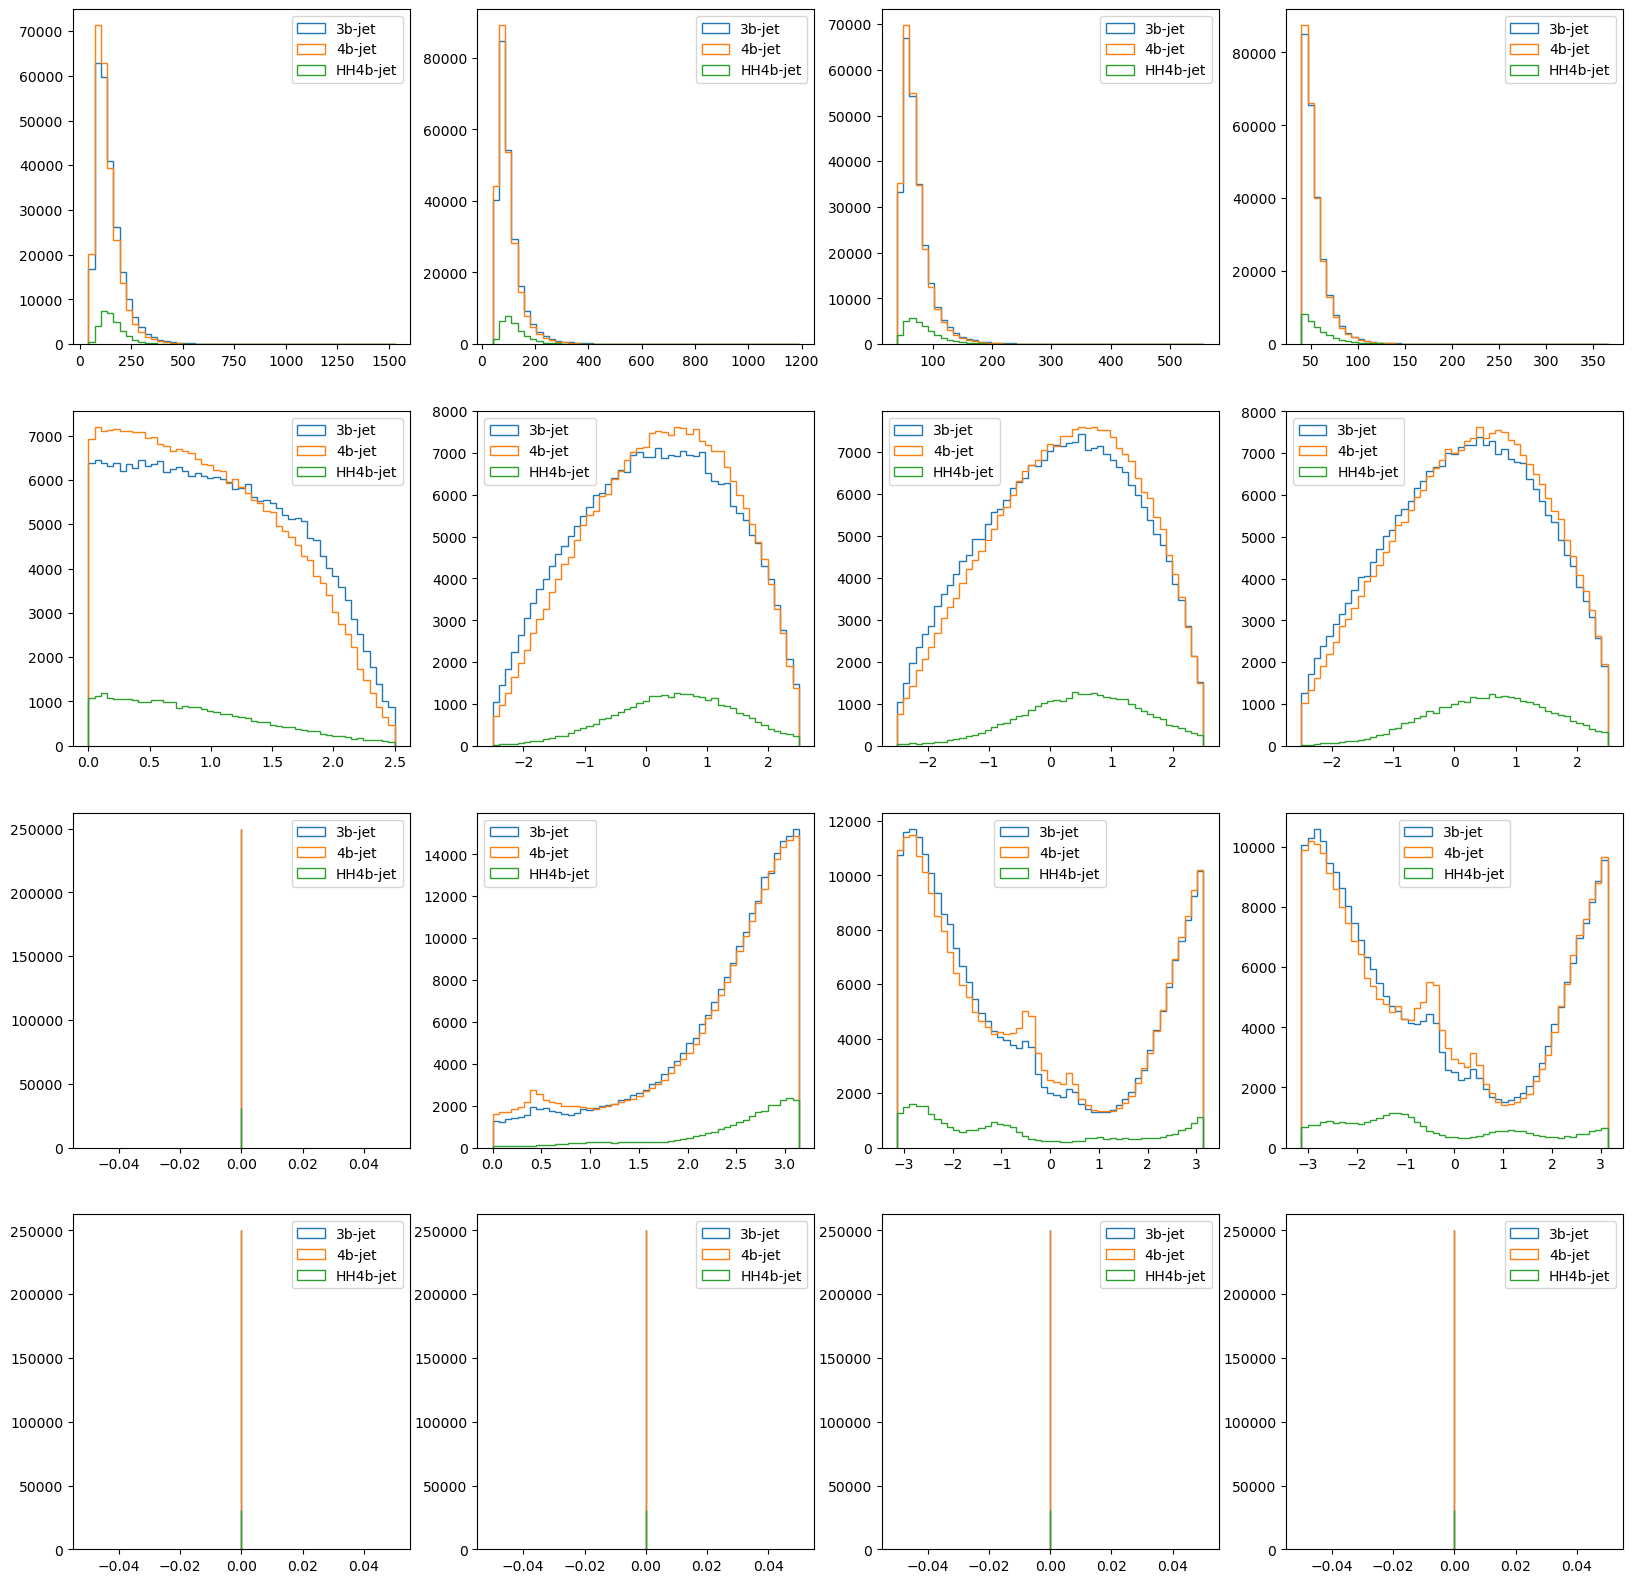

In [3]:
features = ["sym_Jet0_pt", "sym_Jet1_pt", "sym_Jet2_pt", "sym_Jet3_pt",
            "sym_Jet0_eta", "sym_Jet1_eta", "sym_Jet2_eta", "sym_Jet3_eta",
            "sym_Jet0_phi", "sym_Jet1_phi", "sym_Jet2_phi", "sym_Jet3_phi",
            "sym_Jet0_m", "sym_Jet1_m", "sym_Jet2_m", "sym_Jet3_m"]

# EDA: plot each features
import matplotlib.pyplot as plt

fig, axes = plt.subplots(4, 4, figsize=(20, 20))

for i, feature in enumerate(features):
    bins_range = np.linspace(min(df_3b[feature].min(), df_bg4b[feature].min(), df_hh4b[feature].min()),
                             max(df_3b[feature].max(), df_bg4b[feature].max(), df_hh4b[feature].max()),
                             50)
    ax = axes[i // 4, i % 4]
    ax.hist(df_3b[feature], label="3b-jet", histtype="step", bins=bins_range)
    ax.hist(df_bg4b[feature], label="4b-jet", histtype="step", bins=bins_range)
    ax.hist(df_hh4b[feature], label="HH4b-jet", histtype="step", bins=bins_range)
    ax.legend()

plt.show()
plt.close()

In [4]:
# Training 

signal_ratio = 0.05
    
import pytorch_lightning as pl
from torch.utils.data import TensorDataset

pl.seed_everything(seed_)
np.random.seed(seed_)

test_ratio = 0.5

n_3b_train = int(n_3b * (1 - test_ratio))
n_all4b_train = int(n_all4b * (1 - test_ratio))
n_bg4b_train = n_all4b_train - int(n_all4b_train * signal_ratio)
n_hh4b_train = int(n_all4b_train * signal_ratio)


df_3b_train = df_3b.iloc[:n_3b_train]
df_bg4b_train = df_bg4b.iloc[:n_bg4b_train]
df_hh4b_train = df_hh4b.iloc[:n_hh4b_train]
# reweight to match signal_ratio
df_hh4b_train.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_train["weight"]) / np.sum(df_hh4b_train["weight"])) * df_hh4b_train["weight"]
df_train = pd.concat([df_3b_train, df_bg4b_train, df_hh4b_train])
# shuffle the data
df_train = df_train.sample(frac=1, random_state=seed_).reset_index(drop=True)

n_3b_test = n_3b - n_3b_train
n_all4b_test = n_all4b - n_all4b_train
n_bg4b_test = n_all4b_test - int(n_all4b_test * signal_ratio)
n_hh4b_test = int(n_all4b_test * signal_ratio)

df_3b_test = df_3b.iloc[n_3b_train:n_3b_train+n_3b_test]
df_bg4b_test = df_bg4b.iloc[n_bg4b_train:n_bg4b_train+n_bg4b_test]
df_hh4b_test = df_hh4b.iloc[n_hh4b_train:n_hh4b_train+n_hh4b_test]
df_hh4b_test.loc[:, "weight"] = (signal_ratio / (1 - signal_ratio)) * (
                            np.sum(df_bg4b_test["weight"]) / np.sum(df_hh4b_test["weight"])) * df_hh4b_test["weight"]
df_test = pd.concat([df_3b_test, df_bg4b_test, df_hh4b_test])
df_test = df_test.sample(frac=1, random_state=seed_).reset_index(drop=True)

# reduce number of 4b samples to 1/8
print("4b ratio: ", df_train.loc[df_train["fourTag"], "weight"].sum() / df_train["weight"].sum())
print("Signal ratio: ", df_train.loc[df_train["signal"], "weight"].sum() / df_train.loc[df_train["fourTag"], "weight"].sum())

from split_samples import split_samples

(X_train, y_train, w_train, is_signal_train), (X_val, y_val, w_val, is_signal_val) = split_samples(
    df_train[features].values, df_train["fourTag"].values, df_train["weight"].values, df_train["signal"].values,
    at=2/3, div=1024)

X_val_torch = torch.tensor(X_val, dtype=torch.float32)
y_val_torch = torch.tensor(y_val, dtype=torch.long)
w_val_torch = torch.tensor(w_val, dtype=torch.float32)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                                torch.tensor(y_train, dtype=torch.long),
                                torch.tensor(w_train, dtype=torch.float32))
val_dataset = TensorDataset(X_val_torch, y_val_torch, w_val_torch)

###########################################################################################
###########################################################################################

from fvt_classifier import FvTClassifier

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 50
run_name = "_".join(["fvt_picoAOD", 
                    f"signal_ratio={signal_ratio}", 
                    f"dijet={dim_dijet_features}", 
                    f"quadjet={dim_quadjet_features}", 
                    f"n_3b={n_3b}",
                    f"n_all4b={n_all4b}",
                    f"epochs={max_epochs}",
                    f"seed={seed_}",
                    ])
lr = 1e-3

Seed set to 42


4b ratio:  0.4770373
Signal ratio:  0.050000004


# Test dataset (Not validation dataset)

In [5]:
print("Test Data")
from fvt_representations import get_fvt_reprs
from torch.utils.data import DataLoader

(X_test, y_test, w_test, is_signal_test), _ = split_samples(
    df_test[features].values, df_test["fourTag"].values, df_test["weight"].values, df_test["signal"].values,
    at=1) # no need to be multiplier of 1024

X_test_torch = torch.tensor(X_test, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.long)
w_test_torch = torch.tensor(w_test, dtype=torch.float32)

svb_test_dataset = TensorDataset(X_test_torch, y_test_torch, w_test_torch)

fvt_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{run_name}_best.ckpt")
fvt_model.eval()
test_loader = DataLoader(svb_test_dataset, batch_size=1024, shuffle=False)
device = torch.device("cuda:0")
fvt_model = fvt_model.to(device)

q_repr_test, view_scores_test = get_fvt_reprs(X_test_torch, fvt_model, device)
labels_4b_test = y_test
probs_4b_test = fvt_model.predict(X_test_torch)[:, 1].cpu().detach().numpy()

is_3b_test = labels_4b_test == 0
is_4b_test = labels_4b_test == 1
is_bg4b_test = (labels_4b_test == 1) & (is_signal_test == 0)
is_hh4b_test = (labels_4b_test == 1) & (is_signal_test == 1)

Test Data


**Test Data**


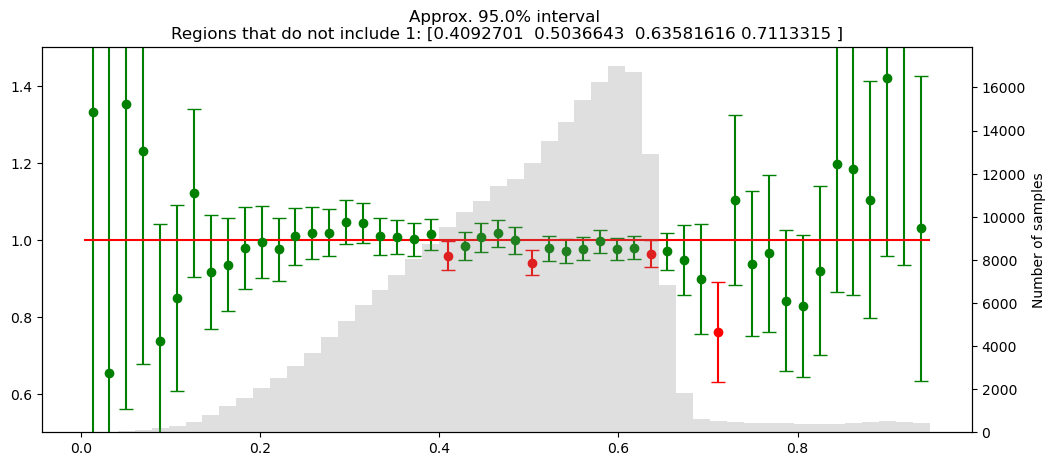

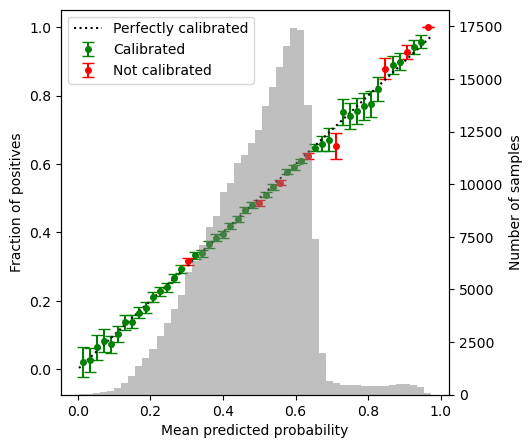

In [6]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

print("**Test Data**")


plot_prob_weighted_histogram1d(probs_4b_test, probs_4b_test, labels_4b_test,
                               n_bins=50, 
                               sample_weights=w_test,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_test, labels_4b_test,
                 bins=50,
                 sample_weights=w_test)

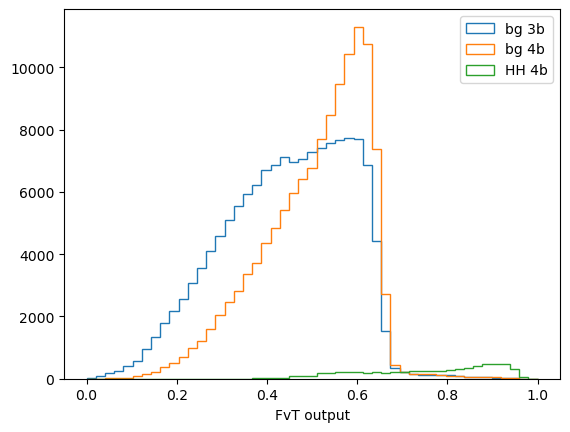

Plotting 5899 per class with prob4b > 0.5


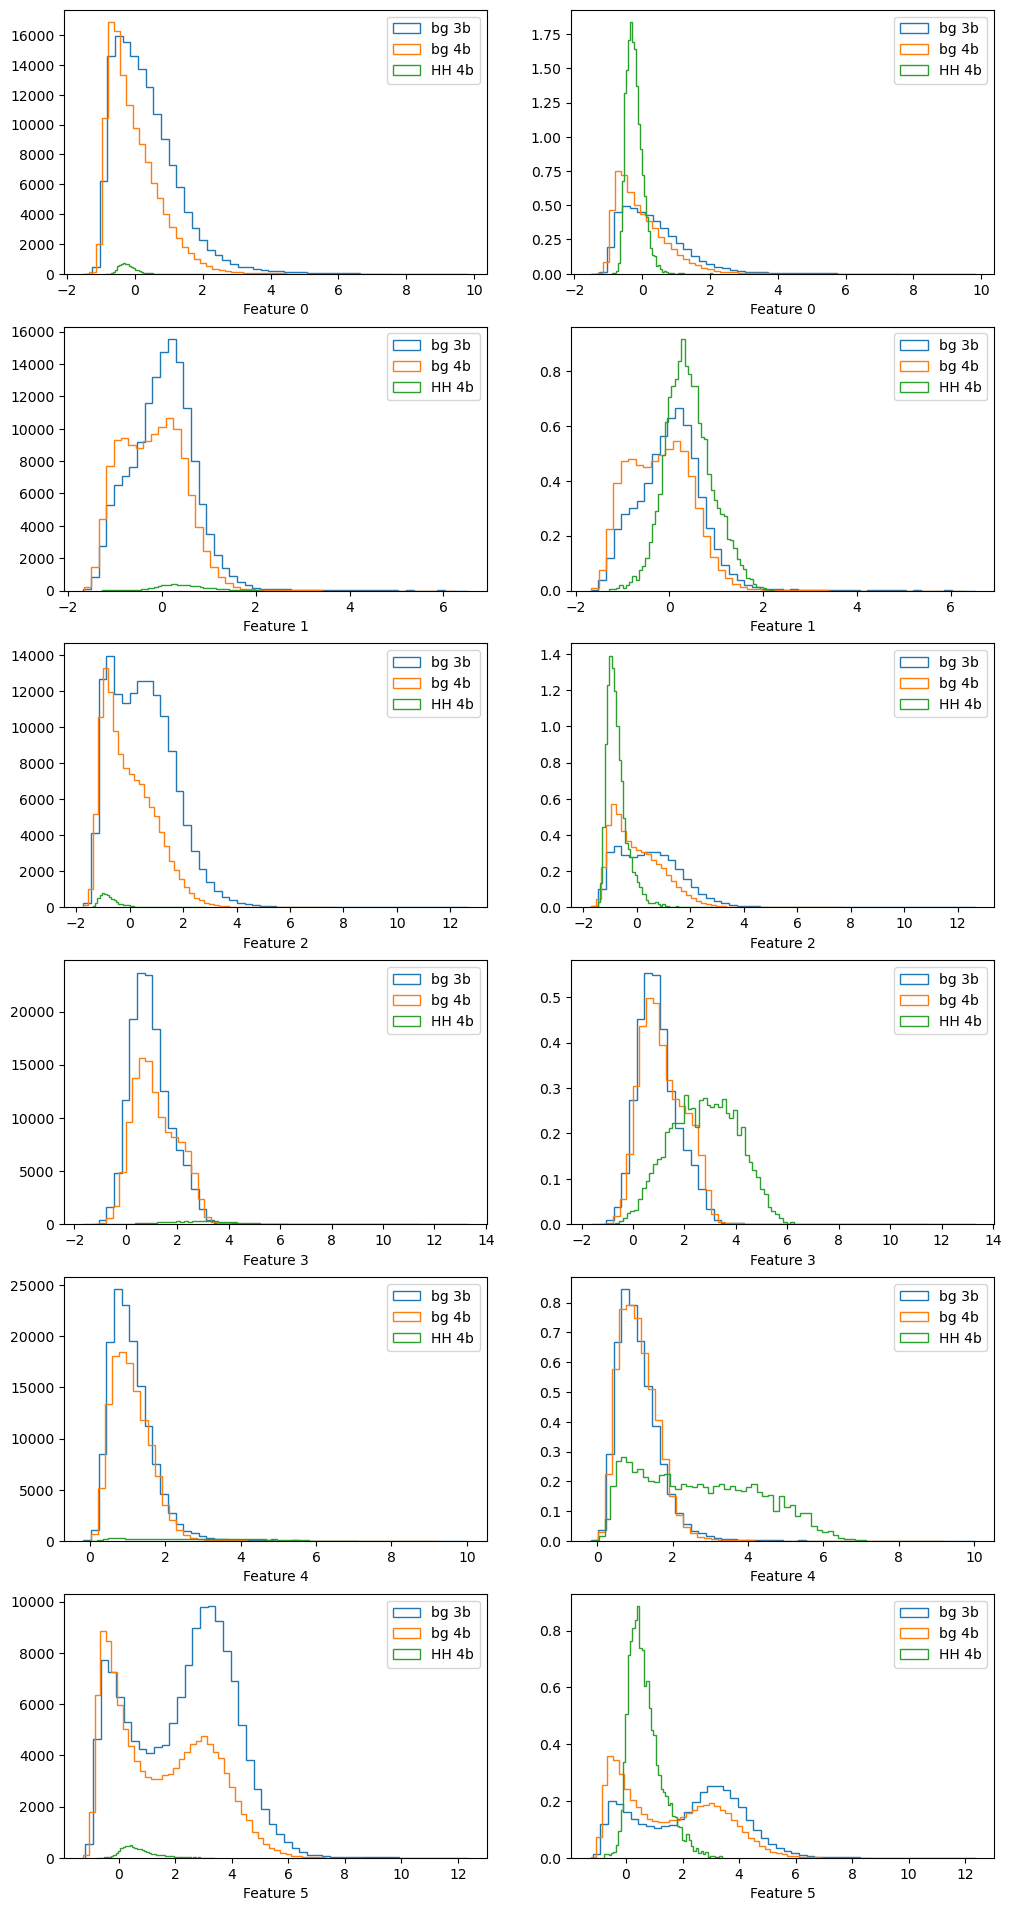

In [7]:
import matplotlib.pyplot as plt

# Pair plots with prob4b threshold

fig, ax = plt.subplots()
bins_range = np.linspace(0, 1, 50)
ax.hist(probs_4b_test[is_3b_test], bins=bins_range, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
ax.hist(probs_4b_test[is_bg4b_test], bins=bins_range, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
ax.hist(probs_4b_test[is_hh4b_test], bins=bins_range, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_hh4b_test])
ax.legend()
ax.set_xlabel("FvT output")
plt.show()

probs_4b_threshold = 0.5
probs_4b_exceeded = probs_4b_test > probs_4b_threshold

n_points = min(np.sum(is_3b_test & probs_4b_exceeded), np.sum(is_bg4b_test & probs_4b_exceeded), np.sum(is_hh4b_test & probs_4b_exceeded))
print(f"Plotting {n_points} per class with prob4b > {probs_4b_threshold}")

is_3b_plot = np.random.choice(np.where(is_3b_test & probs_4b_exceeded)[0], n_points, replace=False)
is_bg4b_plot = np.random.choice(np.where(is_bg4b_test & probs_4b_exceeded)[0], n_points, replace=False)
is_hh4b_plot = np.random.choice(np.where(is_hh4b_test & probs_4b_exceeded)[0], n_points, replace=False)
att_q_repr_test = (q_repr_test @ view_scores_test[:, :, None]).reshape(-1, dim_quadjet_features)

fig, ax = plt.subplots(nrows=6, ncols=2, figsize=(12, 24))

for i in range(dim_quadjet_features):
    ax[i, 0].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=False, weights=w_test[is_3b_test])
    ax[i, 0].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_bg4b_test])
    ax[i, 0].hist(att_q_repr_test[is_hh4b_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=False, weights=w_test[is_hh4b_test])
    ax[i, 0].legend()
    ax[i, 0].set_xlabel(f"Feature {i}")
    
    ax[i, 1].hist(att_q_repr_test[is_3b_test, i], bins=50, label="bg 3b", linewidth=1, histtype="step", density=True, weights=w_test[is_3b_test])
    ax[i, 1].hist(att_q_repr_test[is_bg4b_test, i], bins=50, label="bg 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_bg4b_test])
    ax[i, 1].hist(att_q_repr_test[is_hh4b_test, i], bins=50, label="HH 4b", linewidth=1, histtype="step", density=True, weights=w_test[is_hh4b_test])
    ax[i, 1].legend()
    ax[i, 1].set_xlabel(f"Feature {i}")

plt.show()
plt.close()


Thresholded samples
3b:  3498
bg4b:  5510
hh4b:  992


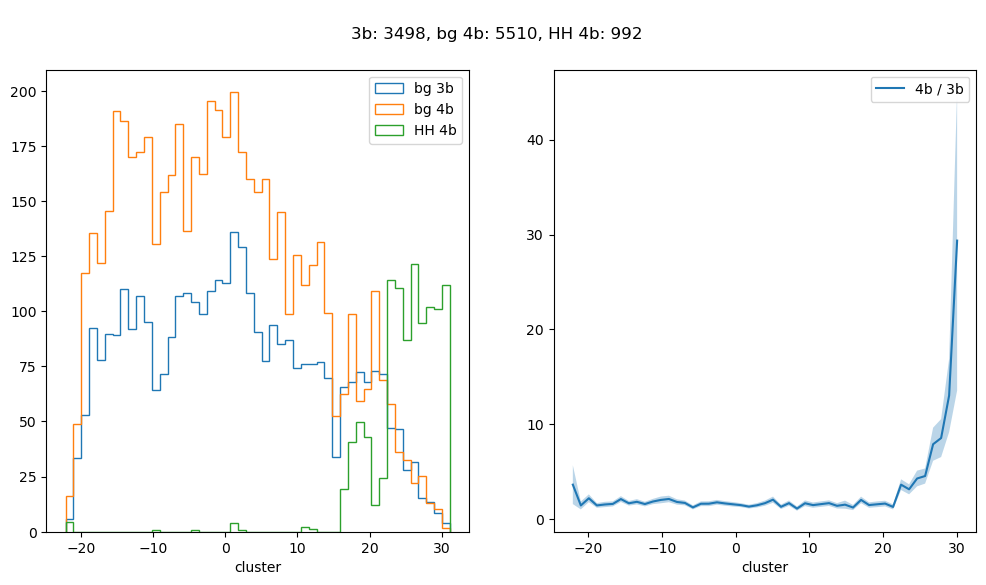

Failed samples
3b:  106826
bg4b:  90145
hh4b:  1249


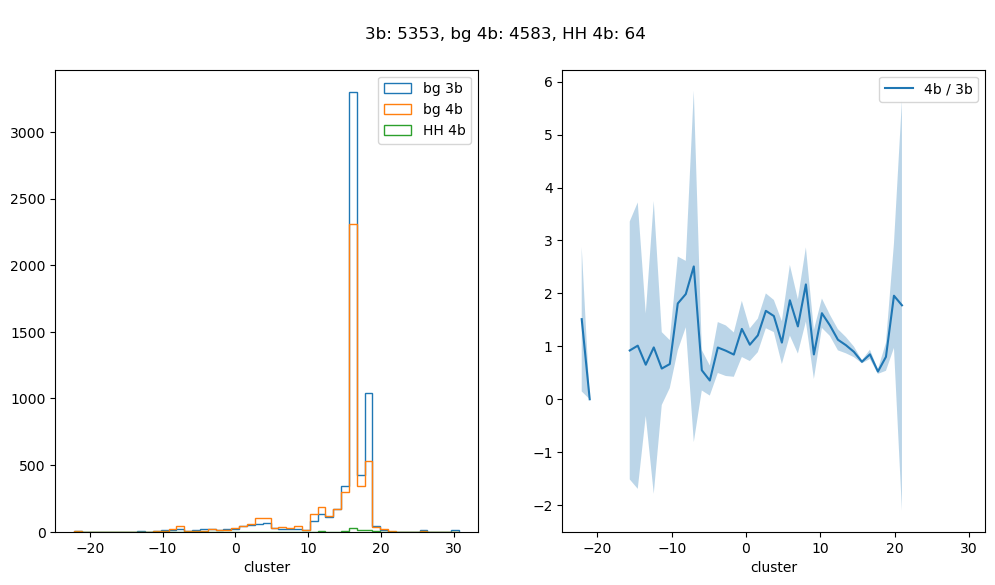

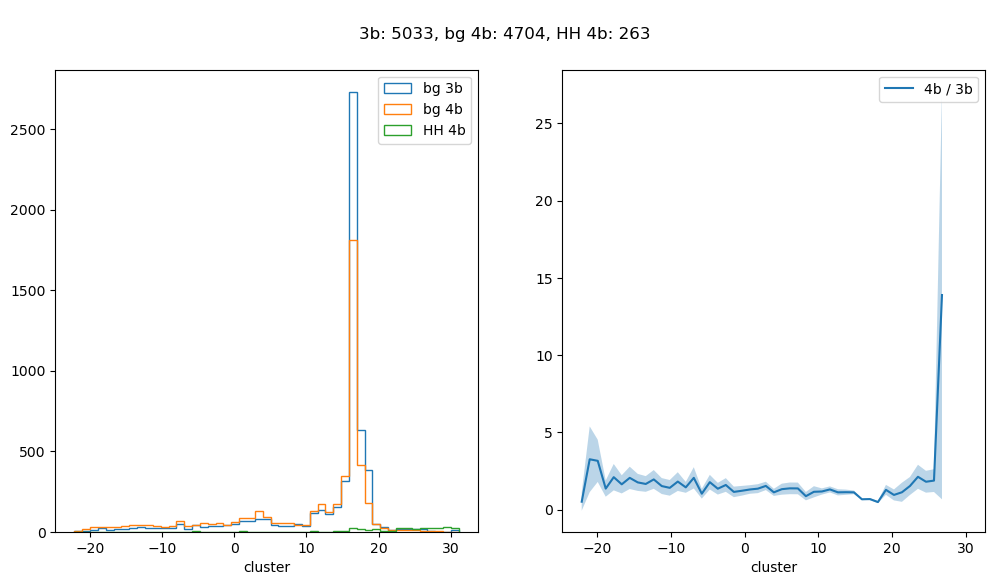

In [74]:
import umap
from sklearn.manifold import TSNE
from plots import plot_cluster

n_components = 1
umap_reducer = umap.UMAP(n_components=n_components)
tsne_reducer = TSNE(n_components=n_components, random_state=seed_)

reducer = umap_reducer

# TSNE seems not to work well
# tsne_reducer.transform is not implemented
# reducer = tsne_reducer

# random sample of 10000 points

probs_4b_threshold = 0.6
probs_4b_exceeded = probs_4b_test > probs_4b_threshold

n_points = min(np.sum(probs_4b_exceeded), 10000)
np.random.seed(seed_)
cluster_samples = np.random.choice(np.where(probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(~probs_4b_exceeded)[0], n_points, replace=False)
# cluster_samples = np.random.choice(np.where(probs_4b_exceeded & (~is_signal_test))[0], n_points, replace=False)
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = w_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

# print number of points in each class
print("Thresholded samples")
print("3b: ", np.sum(is_3b_cluster))
print("bg4b: ", np.sum(is_bg4b_cluster))
print("hh4b: ", np.sum(is_hh4b_cluster))

# cluster_repr_test = umap_reducer.fit_transform(q_repr_cluster.reshape(-1, 3*dim_quadjet_features))

# plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_test = reducer.fit_transform(att_q_repr_cluster)

plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)


# failed samples
print("Failed samples")
print("3b: ", np.sum(is_3b_test & ~probs_4b_exceeded))
print("bg4b: ", np.sum(is_bg4b_test & ~probs_4b_exceeded))
print("hh4b: ", np.sum(is_hh4b_test & ~probs_4b_exceeded))

thrs_fail_samples = np.random.choice(np.where(probs_4b_test < probs_4b_threshold)[0], min(n_points, np.sum(probs_4b_test < probs_4b_threshold)), replace=False)
q_repr_fail = q_repr_test[thrs_fail_samples]
is_3b_fail = labels_4b_test[thrs_fail_samples] == 0
is_bg4b_fail = (labels_4b_test[thrs_fail_samples] == 1) & (is_signal_test[thrs_fail_samples] == 0)
is_hh4b_fail = is_signal_test[thrs_fail_samples] == 1
weights_fail = w_test[thrs_fail_samples]
view_scores_fail = view_scores_test[thrs_fail_samples]

att_q_repr_fail = (q_repr_fail @ view_scores_fail[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_fail = reducer.transform(att_q_repr_fail)

plot_cluster(cluster_repr_fail, is_3b_fail, is_bg4b_fail, is_hh4b_fail, weights_fail, n_components=n_components)


# all samples
np.random.seed(seed_)
cluster_samples = np.random.choice(np.arange(len(probs_4b_test)), 10000, replace=False)
q_repr_cluster = q_repr_test[cluster_samples]
is_3b_cluster = labels_4b_test[cluster_samples] == 0
is_bg4b_cluster = (labels_4b_test[cluster_samples] == 1) & (is_signal_test[cluster_samples] == 0)
is_hh4b_cluster = is_signal_test[cluster_samples] == 1
weights_cluster = w_test[cluster_samples]
view_scores_cluster = view_scores_test[cluster_samples]

att_q_repr_cluster = (q_repr_cluster @ view_scores_cluster[:, :, None]).reshape(-1, dim_quadjet_features)
cluster_repr_test = reducer.transform(att_q_repr_cluster)

plot_cluster(cluster_repr_test, is_3b_cluster, is_bg4b_cluster, is_hh4b_cluster, weights_cluster, n_components=n_components)

umap_embed_test = reducer.transform(att_q_repr_test)

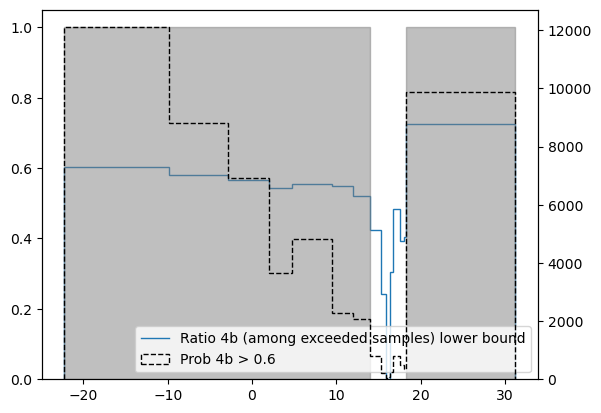

Sideband
3b:  99761.92
bg4b:  69217.48
hh4b:  1364.909

Signal Region
3b:  43065.2
bg4b:  54662.14
hh4b:  5155.0713

Portion of Signal in Signal Region
hh4b:  0.79065746

SR / (SR + SB)
0.37654594


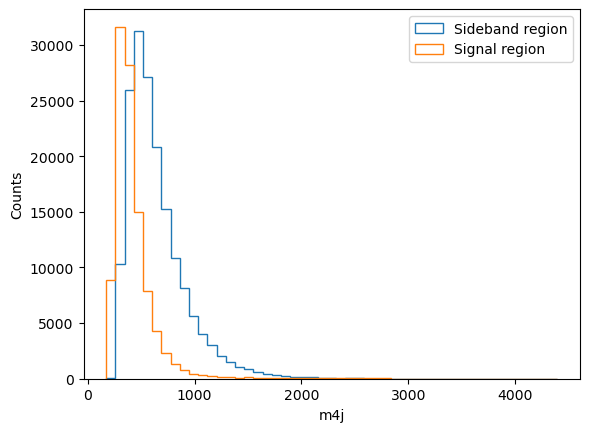

In [75]:
n_bins = 20
# what if we only use thresholded samples for SR selection?

percentiles_all = np.percentile(umap_embed_test[:, 0], np.linspace(0, 100, n_bins + 1))

hist_3b_all, _ = np.histogram(umap_embed_test[is_3b_test, 0], bins=percentiles_all, weights=w_test[is_3b_test])
hist_bg4b_all, _ = np.histogram(umap_embed_test[is_bg4b_test, 0], bins=percentiles_all, weights=w_test[is_bg4b_test])
hist_hh4b_all, _ = np.histogram(umap_embed_test[is_hh4b_test, 0], bins=percentiles_all, weights=w_test[is_hh4b_test])

ratio_4b_all = (hist_bg4b_all + hist_hh4b_all) / (hist_3b_all + hist_bg4b_all + hist_hh4b_all)

umap_embed_exceeded = umap_embed_test[probs_4b_exceeded]
is_3b_exceeded = is_3b_test[probs_4b_exceeded]
is_bg4b_exceeded = is_bg4b_test[probs_4b_exceeded]
is_hh4b_exceeded = is_hh4b_test[probs_4b_exceeded]
w_exceeded = w_test[probs_4b_exceeded]

# percentiles_exceeded = np.percentile(umap_embed_exceeded[:, 0], np.linspace(0, 100, n_bins + 1))

hist_3b_exceeded, _ = np.histogram(umap_embed_exceeded[is_3b_exceeded, 0], bins=percentiles_all, weights=w_exceeded[is_3b_exceeded])
hist_bg4b_exceeded, _ = np.histogram(umap_embed_exceeded[is_bg4b_exceeded, 0], bins=percentiles_all, weights=w_exceeded[is_bg4b_exceeded])
hist_hh4b_exceeded, _ = np.histogram(umap_embed_exceeded[is_hh4b_exceeded, 0], bins=percentiles_all, weights=w_exceeded[is_hh4b_exceeded])

hist_total_exceeded = hist_3b_exceeded + hist_bg4b_exceeded + hist_hh4b_exceeded

ratio_4b_exceeded = (hist_bg4b_exceeded + hist_hh4b_exceeded) / (hist_3b_exceeded + hist_bg4b_exceeded + hist_hh4b_exceeded)

alpha = 0.05
l2a = np.log(2 / alpha)
var_ratio_4b_exceeded = ratio_4b_exceeded * (1 - ratio_4b_exceeded) 
# bernstein style error
ratio_4b_exceeded_err = 4 * np.sqrt(var_ratio_4b_exceeded * l2a / hist_total_exceeded) + 4 * l2a / hist_total_exceeded
# ratio_4b_exceeded_err = 0
ratio_4b_exceeded_lower = np.maximum(0, ratio_4b_exceeded - ratio_4b_exceeded_err)


fig, ax = plt.subplots()
ax.stairs(ratio_4b_exceeded_lower, percentiles_all, fill=False, label="Ratio 4b (among exceeded samples) lower bound")


# select top 50% of bins that has highest ratio_4b
# But do this based on all the samples even if ratio_4b is calculated only for thresholded samples
sr_ratio = 0.4

n_top = int(n_bins * sr_ratio)
top_bins = np.argsort(ratio_4b_exceeded_lower)[-n_top:]


# merge top_bins
top_bins = np.sort(top_bins)
top_bin_edges = [(percentiles_all[i], percentiles_all[i+1]) for i in top_bins]
for i, (low, high) in enumerate(top_bin_edges):
    if i == 0:
        merged_bin_edges = [(low, high)]
    else:
        prev_low, prev_high = merged_bin_edges[-1]
        if low <= prev_high:
            merged_bin_edges[-1] = (prev_low, high)
        else:
            merged_bin_edges.append((low, high))

# fill merged bins in the figure
# custom
# merged_bin_edges = [(percentiles[i], percentiles[i+1]) for i in range(1, n_bins, 2)]

for low, high in merged_bin_edges:
    rect = plt.Rectangle((low, 0), high - low, 1, color="gray", alpha=0.5)
    ax.add_patch(rect)

ax2 = ax.twinx()
ax2.hist(umap_embed_exceeded[:, 0], bins=percentiles_all, weights=w_exceeded, histtype="step", color="black", linestyle="--", label=f"Prob 4b > {probs_4b_threshold}")

# merge legends of two axes
lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2, loc="lower right")

plt.show()
plt.close()

is_in_sr = np.any([((umap_embed_test[:, 0] >= low) & (umap_embed_test[:, 0] < high)) 
                    for low, high in merged_bin_edges], axis=0)

X_sr = X_test[is_in_sr]
y_sr = y_test[is_in_sr]
w_sr = w_test[is_in_sr]
is_3b_sr = is_3b_test[is_in_sr]
is_4b_sr = is_4b_test[is_in_sr]
is_bg4b_sr = is_bg4b_test[is_in_sr]
is_hh4b_sr = is_hh4b_test[is_in_sr]


X_sb = X_test[~is_in_sr]
y_sb = y_test[~is_in_sr]
w_sb = w_test[~is_in_sr]
is_3b_sb = is_3b_test[~is_in_sr]
is_4b_sb = is_4b_test[~is_in_sr]
is_bg4b_sb = is_bg4b_test[~is_in_sr]
is_hh4b_sb = is_hh4b_test[~is_in_sr]

# print weights of 3b, bg4b, hh4b

print("Sideband")
print("3b: ", np.sum(w_sb[is_3b_sb]))
print("bg4b: ", np.sum(w_sb[is_bg4b_sb]))
print("hh4b: ", np.sum(w_sb[is_hh4b_sb]))
print("")

print("Signal Region")
print("3b: ", np.sum(w_sr[is_3b_sr]))
print("bg4b: ", np.sum(w_sr[is_bg4b_sr]))
print("hh4b: ", np.sum(w_sr[is_hh4b_sr]))
print("")

print("Portion of Signal in Signal Region")
print("hh4b: ", np.sum(w_sr[is_hh4b_sr]) / np.sum(w_test[is_hh4b_test]))
print("")
print("SR / (SR + SB)")
print(np.sum(w_sr) / (np.sum(w_sr) + np.sum(w_sb)))

from ancillary_features import get_m4j

m4j_sb = get_m4j(torch.tensor(X_sb, dtype=torch.float32))
m4j_sr = get_m4j(torch.tensor(X_sr, dtype=torch.float32))

# plot histograms of m4j
bins_range = np.linspace(min(np.min(m4j_sb), np.min(m4j_sr)), max(np.max(m4j_sb), np.max(m4j_sr)), 50)

plt.hist(m4j_sb, bins=bins_range, weights=w_sb, histtype="step", label="Sideband region")
plt.hist(m4j_sr, bins=bins_range, weights=w_sr, histtype="step", label="Signal region")
plt.xlabel("m4j")
plt.ylabel("Counts")
plt.legend()
plt.show()
plt.close()



In [76]:
sb_run_name = "_".join([
    run_name,
    "sb",
    f"sr_ratio={sr_ratio}",
    f"probs_4b_threshold={probs_4b_threshold}",
    "pick_high_ratio_4b_exceeded"
])

# sb_run_name = "_".join([
#     run_name,
#     "sb",
#     "custom_even",
# ])

train_sb = True

(X_sb_train, y_sb_train, w_sb_train), (X_sb_val, y_sb_val, w_sb_val) = split_samples(X_sb, y_sb, w_sb, at=2/3, div=1024)


sb_train_dataset = TensorDataset(torch.tensor(X_sb_train, dtype=torch.float32),
                                torch.tensor(y_sb_train, dtype=torch.long),
                                torch.tensor(w_sb_train, dtype=torch.float32))

X_sb_val_torch = torch.tensor(X_sb_val, dtype=torch.float32)
y_sb_val_torch = torch.tensor(y_sb_val, dtype=torch.long)
w_sb_val_torch = torch.tensor(w_sb_val, dtype=torch.float32)

sb_val_dataset = TensorDataset(X_sb_val_torch, y_sb_val_torch, w_sb_val_torch)

# Train SB FvT 

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 20
lr = 1e-3

if train_sb:
    pl.seed_everything(42)

    sb_model = FvTClassifier(num_classes, 
                        dim_input_jet_features, 
                        dim_dijet_features, 
                        dim_quadjet_features, 
                        run_name=sb_run_name,
                        device=torch.device("cuda:0"),
                        lr=lr)

    sb_model.fit(sb_train_dataset, sb_val_dataset, batch_size=1024, max_epochs=max_epochs)

Seed set to 42


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:653: Checkpoint directory /home/soheuny/HH4bsim/playground/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name     | Type       | Params
----------------------------------------
0 | encoder  | FvTEncoder | 920   
1 | select_q | conv1d     | 8     
2 | out      | conv1d     | 16    
----------------------------------------
895       Trainable params
49        Non-trainable params
944       Total params
0.004     Total estimated model params size (MB)


Epoch 19: 100%|██████████| 97/97 [00:03<00:00, 30.23it/s, v_num=0, val_loss=0.741, train_loss=0.742]

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 97/97 [00:03<00:00, 29.88it/s, v_num=0, val_loss=0.741, train_loss=0.742]


[autoreload of plots failed: Traceback (most recent call last):
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 276, in check
    superreload(m, reload, self.old_objects)
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 500, in superreload
    update_generic(old_obj, new_obj)
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 397, in update_generic
    update(a, b)
  File "/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/IPython/extensions/autoreload.py", line 309, in update_function
    setattr(old, name, getattr(new, name))
ValueError: decorator() requires a code object with 1 free vars, not 0
]


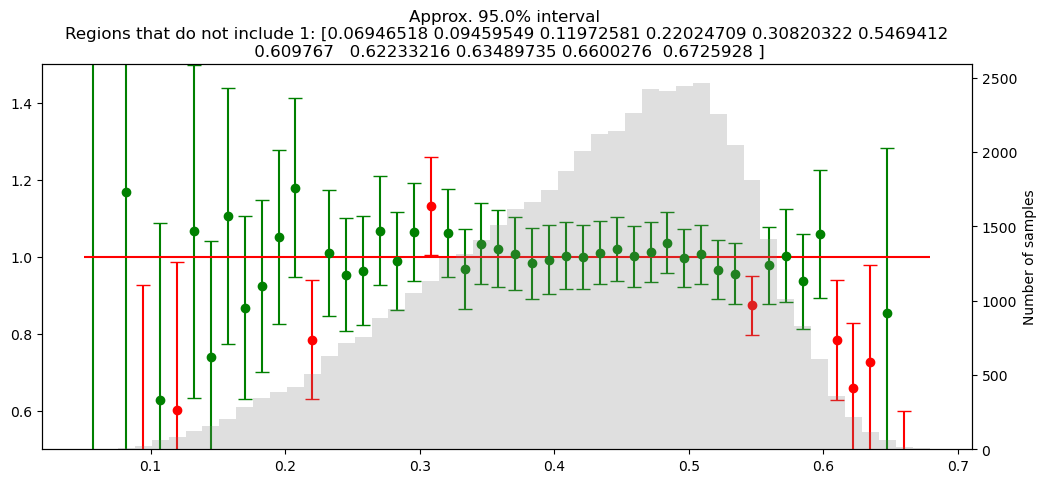

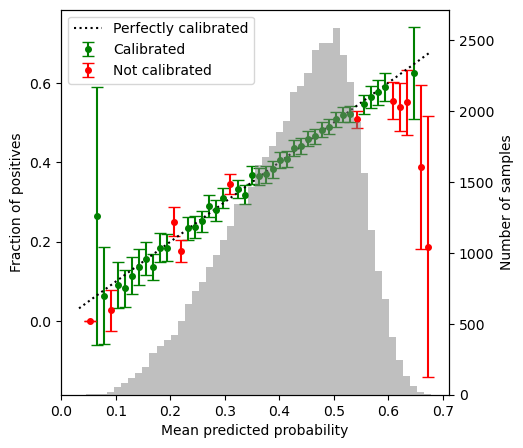

In [85]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

sb_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{sb_run_name}_best.ckpt")
sb_model.eval()
q_repr_sb_val = get_fvt_reprs(X_sb_val_torch, sb_model)[0]
q_repr_sb_val = np.concatenate(q_repr_sb_val, axis=0)
labels_4b_sb_val = y_sb_val
probs_4b_sb_val = sb_model.predict(X_sb_val_torch)[:, 1].cpu().numpy()
weights_sb_val = w_sb_val


plot_prob_weighted_histogram1d(probs_4b_sb_val, 
                               probs_4b_sb_val, 
                               labels_4b_sb_val,
                               n_bins=50, 
                               sample_weights=weights_sb_val,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_sb_val, labels_4b_sb_val,
                 bins=50,
                 sample_weights=weights_sb_val)

In [78]:
X_sr_torch = torch.tensor(X_sr, dtype=torch.float32)
probs_4b_sb_sr = sb_model.predict(X_sr_torch)[:, 1].cpu().numpy()
probs_4b_fvt_sr = fvt_model.predict(X_sr_torch)[:, 1].cpu().numpy()

In [79]:
is_in_sb = ~is_in_sr

def plot_reweighting(hist_x_test, name, geom):

    hist_x_sr = hist_x_test[is_in_sr]
    hist_x_sb = hist_x_test[is_in_sb]

    # reweight 3b samples by probs_4b_sb_sr / (1 - probs_4b_sb_sr)

    total_3b_sb = np.sum(w_sb[is_3b_sb])
    total_4b_sb = np.sum(w_sb[is_4b_sb])

    total_3b_sr = np.sum(w_sr[is_3b_sr])
    total_4b_sr = np.sum(w_sr[is_4b_sr])

    total_3b_fvt = np.sum(w_test[is_3b_test])
    total_4b_fvt = np.sum(w_test[is_4b_test])

    sb_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_sb / total_3b_sb)
    fvt_reweight_const = (total_4b_sr / total_3b_sr) / (total_4b_fvt / total_3b_fvt)

    reweights_sb_sr = w_sr * np.where(
        is_3b_sr, sb_reweight_const * (probs_4b_sb_sr / (1 - probs_4b_sb_sr)), 1
    )
    reweights_fvt_sr = w_sr * np.where(
        is_3b_sr, fvt_reweight_const * (probs_4b_fvt_sr / (1 - probs_4b_fvt_sr)), 1
    )

    fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
    # bins to be a geometric sequence

    if geom:
        bins_range = np.geomspace(hist_x_test.min(), hist_x_test.max(), 20)
    else:
        bins_range = np.linspace(hist_x_test.min(), hist_x_test.max(), 20)

    hist_3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=w_sr[is_3b_sr]
    )
    hist_rwsb3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=reweights_sb_sr[is_3b_sr]
    )
    hist_rwfvt3b, _ = np.histogram(
        hist_x_sr[is_3b_sr], bins=bins_range, weights=reweights_fvt_sr[is_3b_sr]
    )
    hist_bg4b, _ = np.histogram(
        hist_x_sr[is_bg4b_sr], bins=bins_range, weights=w_sr[is_bg4b_sr]
    )

    # normalize the histograms
    scale_3b = np.sum(hist_bg4b) / np.sum(hist_3b)
    scale_rwsb3b = np.sum(hist_bg4b) / np.sum(hist_rwsb3b)
    scale_rwfvt3b = np.sum(hist_bg4b) / np.sum(hist_rwfvt3b)

    # scale_3b = 1
    # scale_rwsb3b = 1
    # scale_rwfvt3b = 1

    err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
    err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
    err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b

    ax[0].stairs(hist_3b, bins_range, label="3b")
    ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
    ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
    ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Counts")
    ax[0].legend()
    ax[0].set_title("Reweighted 3b vs bg4b")

    z = 1.96
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_3b * hist_3b / hist_bg4b,
        yerr=z * err_3b,
        fmt="o-",
        label="bg4b/3b",
        capsize=5,
        markersize=2,
    )
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_rwsb3b * hist_rwsb3b / hist_bg4b,
        yerr=z * err_rw3b,
        fmt="o-",
        label="bg4b/SB reweighted 3b",
        capsize=5,
        markersize=2,
    )
    ax[1].errorbar(
        (bins_range[1:] + bins_range[:-1]) / 2,
        scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,
        yerr=z * err_rwfvt3b,
        fmt="o-",
        label="bg4b/FvT reweighted 3b",
        capsize=5,
        markersize=2,
    )
    ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
    ax[1].set_ylim(0.5, 1.5)
    ax[1].set_xlabel(name)
    ax[1].set_ylabel("Ratio")
    ax[1].legend()
    ax[1].set_title("Reweighted 3b / bg4b")

    ax[2].hist(
        hist_x_sb,
        bins=bins_range,
        weights=w_sb,
        histtype="step",
        label="Sideband region",
    )
    ax[2].hist(
        hist_x_sr, bins=bins_range, weights=w_sr, histtype="step", label="Signal region"
    )
    ax[2].set_xlabel(name)
    ax[2].set_ylabel("Counts")
    ax[2].legend()
    ax[2].set_title("Signal region vs Sideband region")

    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
    if geom:
        bins_range = np.geomspace(hist_x_test.min(), hist_x_test.max(), 20)
    else:
        bins_range = np.linspace(hist_x_test.min(), hist_x_test.max(), 20)

    ax[0].hist(hist_x_test[is_3b_test], bins=bins_range, histtype="step", label="3b")
    ax[0].hist(
        hist_x_test[is_bg4b_test], bins=bins_range, histtype="step", label="bg4b"
    )
    ax[0].hist(
        hist_x_test[is_hh4b_test], bins=bins_range, histtype="step", label="hh4b"
    )
    ax[0].set_xlabel(name)
    ax[0].set_ylabel("Counts")
    ax[0].set_title("All samples")
    ax[0].legend()

    ax[1].hist(
        hist_x_test[is_3b_test & probs_4b_exceeded],
        bins=bins_range,
        histtype="step",
        label="3b",
    )
    ax[1].hist(
        hist_x_test[is_bg4b_test & probs_4b_exceeded],
        bins=bins_range,
        histtype="step",
        label="bg4b",
    )
    ax[1].hist(
        hist_x_test[is_hh4b_test & probs_4b_exceeded],
        bins=bins_range,
        histtype="step",
        label="hh4b",
    )
    ax[1].set_xlabel(name)
    ax[1].set_ylabel("Counts")
    ax[1].set_title(f"Prob4b > {probs_4b_threshold}")
    ax[1].legend()

    plt.show()
    plt.close()


/tmp/ipykernel_2932845/2138825622.py:59: RuntimeWarning: divide by zero encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_2932845/2138825622.py:60: RuntimeWarning: divide by zero encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_2932845/2138825622.py:61: RuntimeWarning: divide by zero encountered in divide
  err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b
/tmp/ipykernel_2932845/2138825622.py:75: RuntimeWarning: divide by zero encountered in divide
  scale_3b * hist_3b / hist_bg4b,
/home/soheuny/miniconda3/envs/coffea_torch/lib/python3.11/site-packages/matplotlib/axes/_axes.py:3683: RuntimeWarning: invalid value encountered in add
  low, high = dep + np.vstack([-(1 - lolims), 1 - uplims]) * err
/tmp/ipykernel_2932845/2138825622.py:84: RuntimeWarning: divide by zero encountered in divide
  scale_rwsb3b * hist_rwsb3b / hist_bg4b,
/tmp/ipykernel_2932845/2138825622.py:93: RuntimeWarning: di

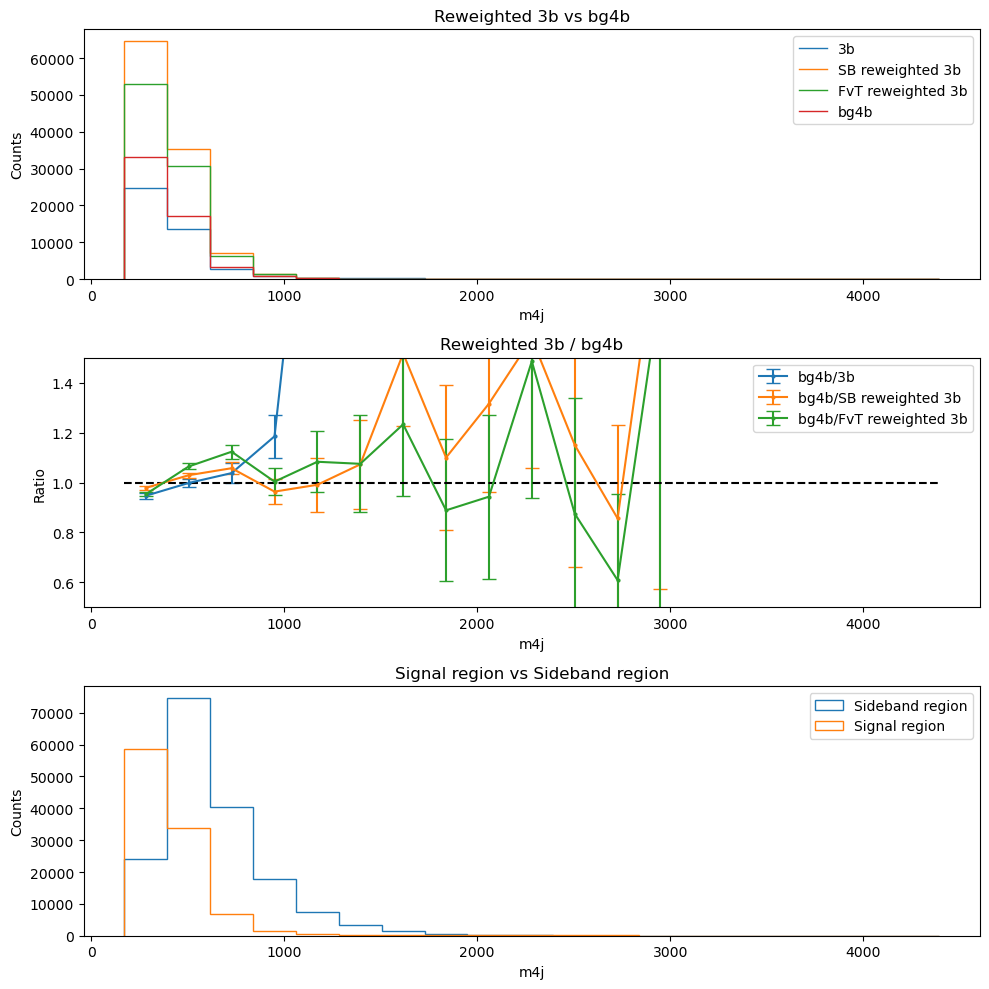

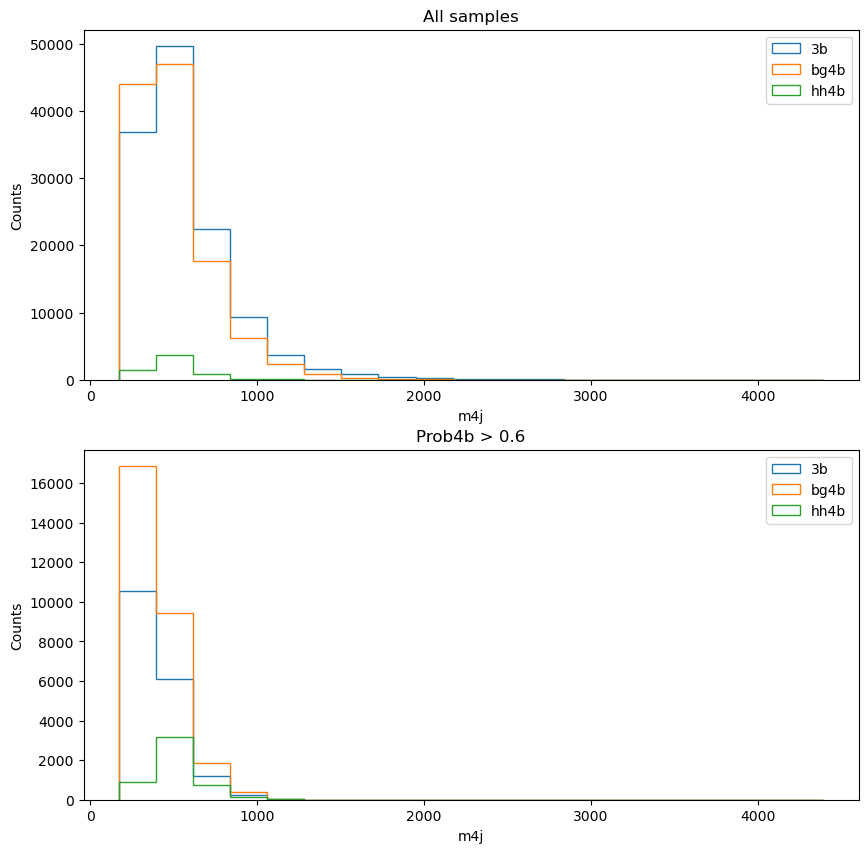

In [80]:
plot_reweighting(get_m4j(torch.tensor(X_test, dtype=torch.float32)), "m4j", geom=False)

/tmp/ipykernel_2932845/2138825622.py:59: RuntimeWarning: invalid value encountered in divide
  err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
/tmp/ipykernel_2932845/2138825622.py:60: RuntimeWarning: invalid value encountered in divide
  err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
/tmp/ipykernel_2932845/2138825622.py:61: RuntimeWarning: invalid value encountered in divide
  err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b
/tmp/ipykernel_2932845/2138825622.py:75: RuntimeWarning: invalid value encountered in divide
  scale_3b * hist_3b / hist_bg4b,
/tmp/ipykernel_2932845/2138825622.py:84: RuntimeWarning: invalid value encountered in divide
  scale_rwsb3b * hist_rwsb3b / hist_bg4b,
/tmp/ipykernel_2932845/2138825622.py:93: RuntimeWarning: invalid value encountered in divide
  scale_rwfvt3b * hist_rwfvt3b / hist_bg4b,


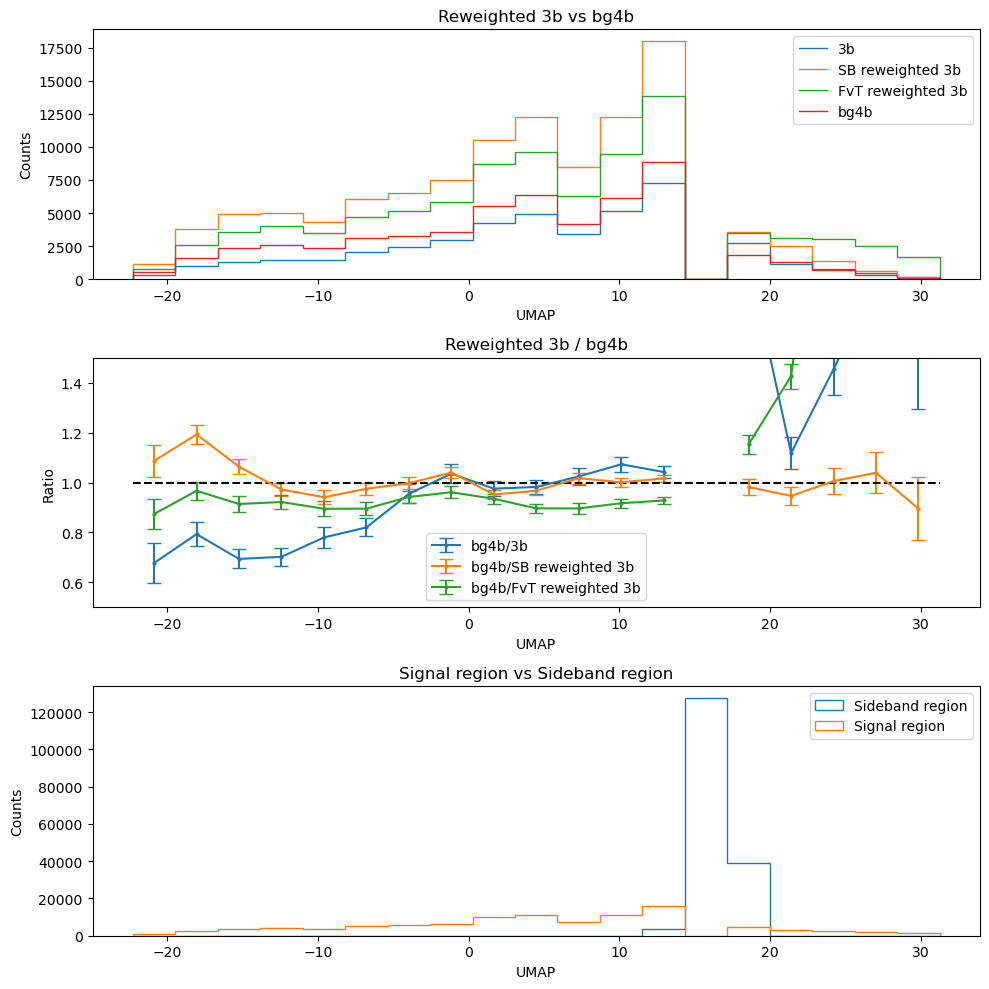

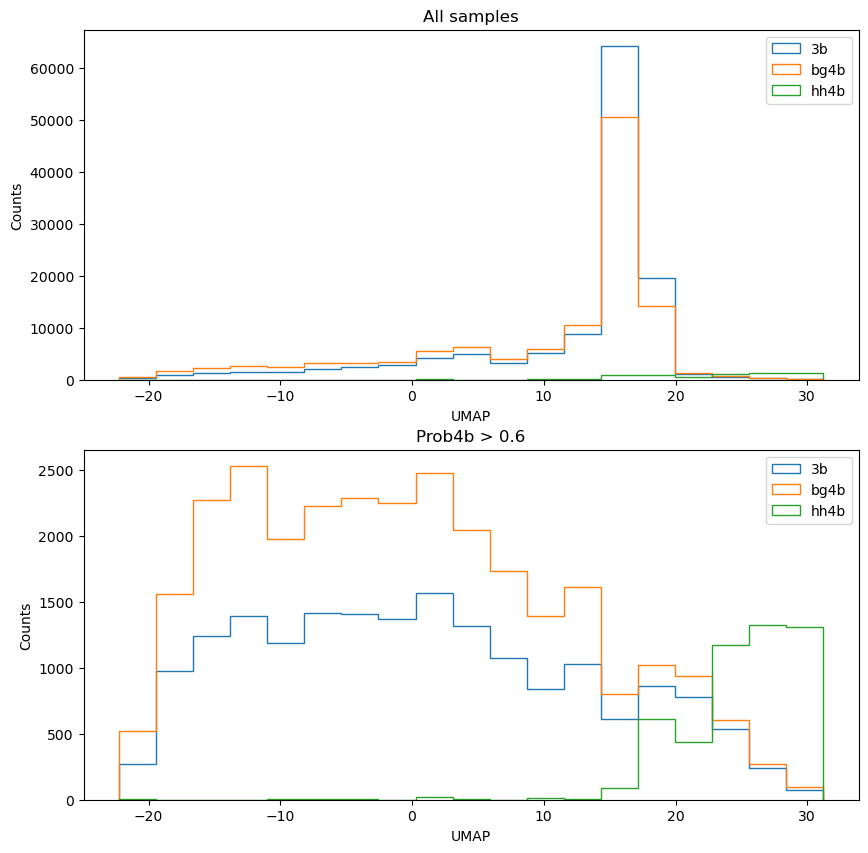

In [81]:
plot_reweighting(umap_embed_test[:, 0], "UMAP", geom=False)

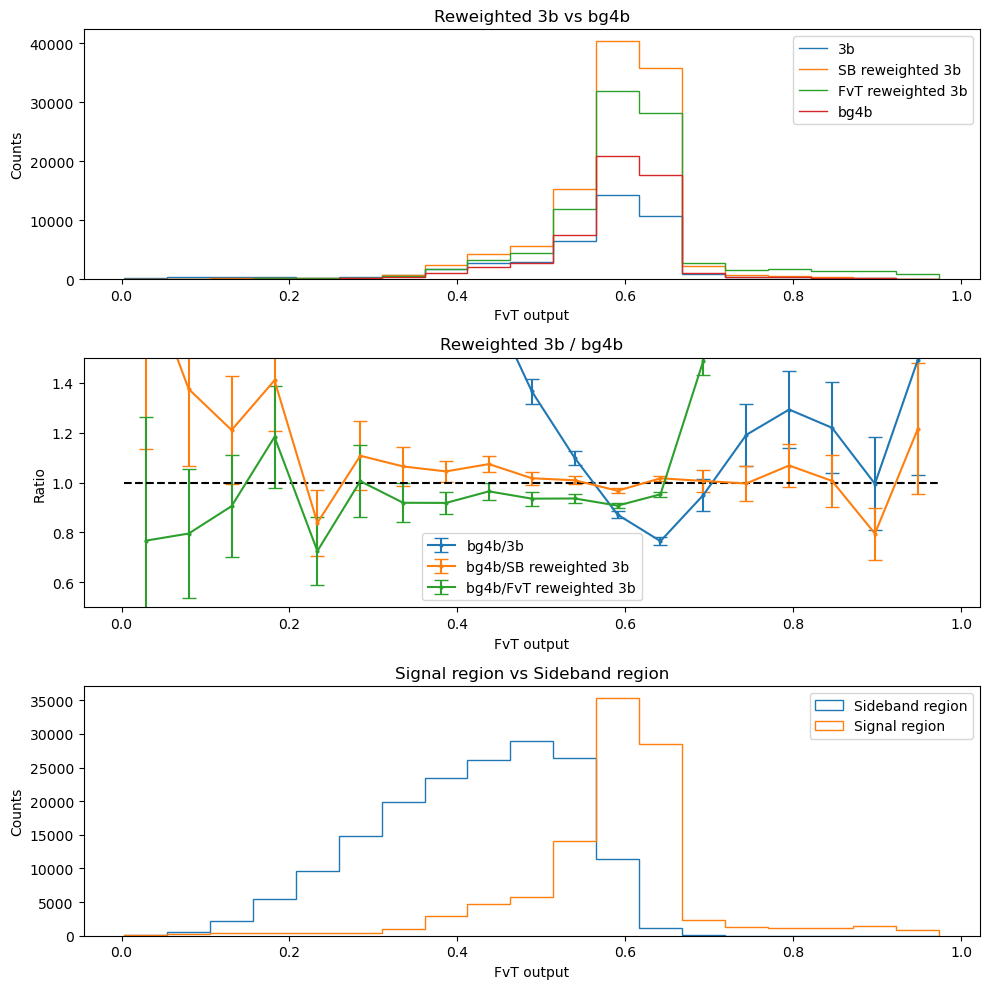

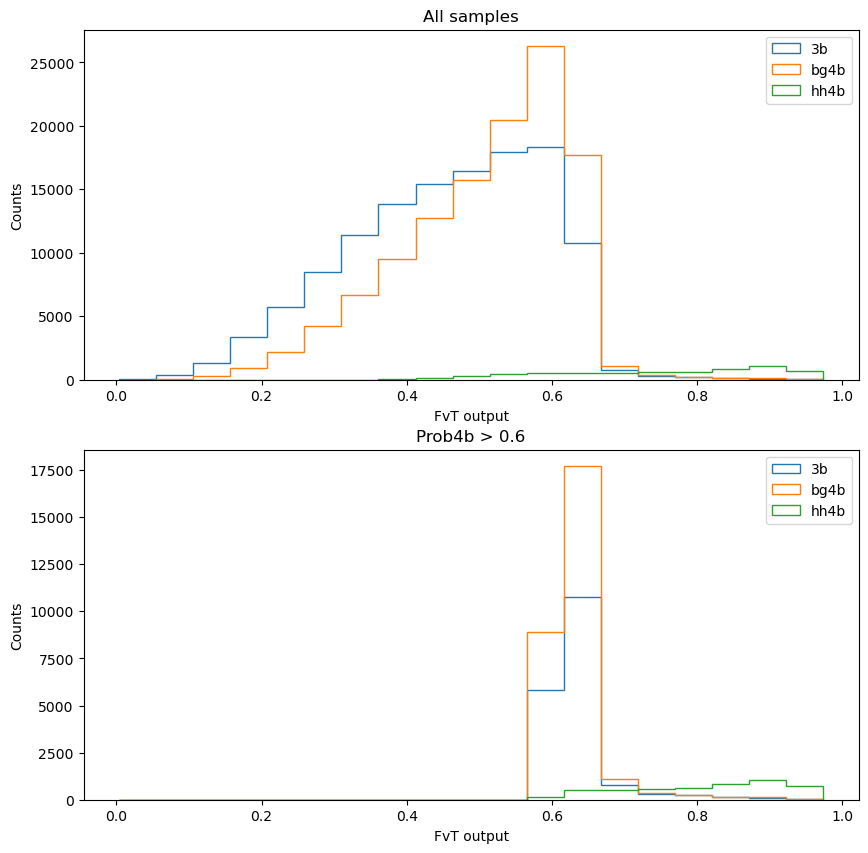

In [82]:
plot_reweighting(probs_4b_test, "FvT output", geom=False)

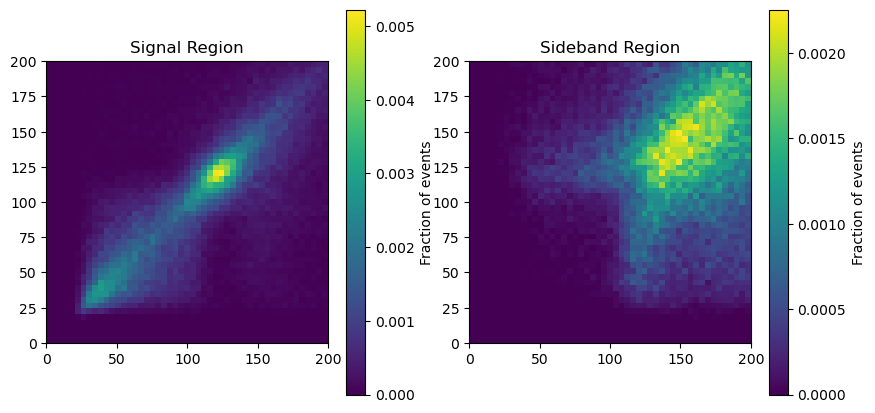

In [83]:
from ancillary_features import jets_to_dijets


jet0 = X_test_torch[:, [4*i for i in range(4)]]
jet1 = X_test_torch[:, [4*i + 1 for i in range(4)]]
jet2 = X_test_torch[:, [4*i + 2 for i in range(4)]]
jet3 = X_test_torch[:, [4*i + 3 for i in range(4)]]

dijet01, dijet23, dijet02, dijet13, dijet03, dijet12 = jets_to_dijets(jet0, jet1, jet2, jet3, dim=2)
M01, M23, M02, M13, M03, M12 = dijet01[:, 3], dijet23[:, 3], dijet02[:, 3], dijet13[:, 3], dijet03[:, 3], dijet12[:, 3]
M01, M23, M02, M13, M03, M12 = M01.cpu().numpy(), M23.cpu().numpy(), M02.cpu().numpy(), M13.cpu().numpy(), M03.cpu().numpy(), M12.cpu().numpy()

m_diff = np.stack(
    [M01 - M23, M02 - M13, M03 - M12],
    axis=1
)
m_diff_argmin = np.argmin(np.abs(m_diff), axis=1)

m_0 = np.where(m_diff_argmin == 0, M01, np.where(m_diff_argmin == 1, M02, M03))
m_1 = np.where(m_diff_argmin == 0, M23, np.where(m_diff_argmin == 1, M13, M12))

x_bins = np.linspace(0, 200, 50)
y_bins = np.linspace(0, 200, 50)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

hist_sr, _, _ = np.histogram2d(m_0[is_in_sr], m_1[is_in_sr], bins=(x_bins, y_bins), weights=w_sr)
hist_sb, _, _ = np.histogram2d(m_0[is_in_sb], m_1[is_in_sb], bins=(x_bins, y_bins), weights=w_sb)

hist_sr = hist_sr.T
hist_sb = hist_sb.T

hist_sr /= np.sum(hist_sr)
hist_sb /= np.sum(hist_sb)

im = ax[0].imshow(hist_sr, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[0])
cbar.set_label("Fraction of events")
ax[0].set_title("Signal Region")

im = ax[1].imshow(hist_sb, extent=(x_bins[0], x_bins[-1], y_bins[0], y_bins[-1]), origin="lower", cmap="viridis")
cbar = plt.colorbar(im, ax=ax[1])
cbar.set_label("Fraction of events")
ax[1].set_title("Sideband Region")


plt.show()
plt.close()


/tmp/ipykernel_2321500/3172231725.py:11: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_2321500/3172231725.py:17: RuntimeWarning:

divide by zero encountered in divide



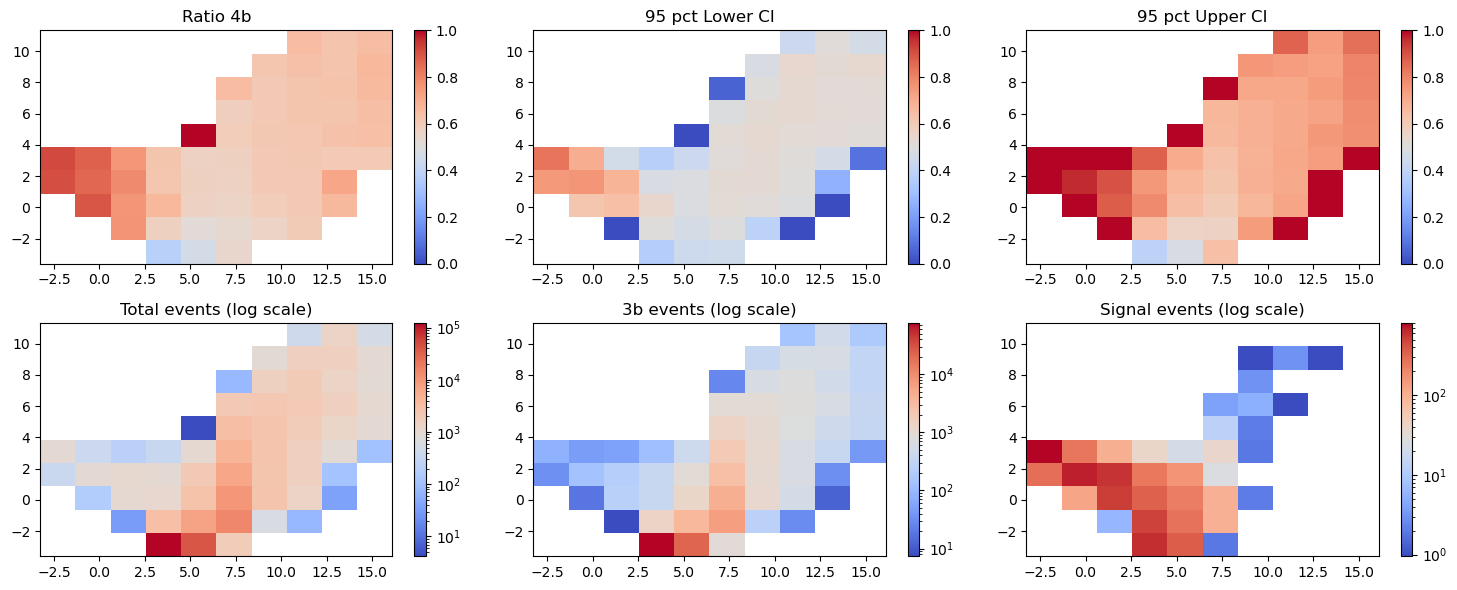

In [ ]:
# 2d histogram of the UMAP embedding
from matplotlib.colors import LogNorm
from scipy import stats

hist_3b, xedges, yedges = np.histogram2d(umap_embed_test[is_3b_test, 0], umap_embed_test[is_3b_test, 1], bins=10, weights=w_test[is_3b_test])
hist_bg4b, _, _ = np.histogram2d(umap_embed_test[is_bg4b_test, 0], umap_embed_test[is_bg4b_test, 1], bins=(xedges, yedges), weights=w_test[is_bg4b_test])
hist_hh4b, _, _ = np.histogram2d(umap_embed_test[is_hh4b_test, 0], umap_embed_test[is_hh4b_test, 1], bins=(xedges, yedges), weights=w_test[is_hh4b_test])

hist_total = hist_3b + hist_bg4b + hist_hh4b

ratio_4b = (hist_bg4b + hist_hh4b) / hist_total

alpha = 0.05
l2a = np.log(2 / alpha)
var_ratio_4b = ratio_4b * (1 - ratio_4b)
# bernstein style error
error = 4 * np.sqrt(var_ratio_4b * l2a / hist_total) + 4 * l2a / hist_total

fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(15, 6))

current_ax = ax[0, 0]
c = current_ax.pcolormesh(xedges, yedges, ratio_4b.T, cmap="coolwarm", vmin=0, vmax=1)
fig.colorbar(c, ax=current_ax)
current_ax.set_title("Ratio 4b")

current_ax = ax[0, 1]
c = current_ax.pcolormesh(xedges, yedges, np.clip((ratio_4b - error).T, 0, 1), cmap="coolwarm", vmin=0, vmax=1)
fig.colorbar(c, ax=current_ax)
current_ax.set_title("95 pct Lower CI")

current_ax = ax[0, 2]
c = current_ax.pcolormesh(xedges, yedges, np.clip((ratio_4b + error).T, 0, 1), cmap="coolwarm", vmin=0, vmax=1)
fig.colorbar(c, ax=current_ax)
current_ax.set_title("95 pct Upper CI")

current_ax = ax[1, 0]
c = current_ax.pcolormesh(xedges, yedges, (hist_3b + hist_bg4b + hist_hh4b).T, cmap="coolwarm", norm=LogNorm())
fig.colorbar(c, ax=current_ax)
current_ax.set_title("Total events (log scale)")


current_ax = ax[1, 1]
c = current_ax.pcolormesh(xedges, yedges, hist_3b.T, cmap="coolwarm", norm=LogNorm())
fig.colorbar(c, ax=current_ax)
current_ax.set_title("3b events (log scale)")

current_ax = ax[1, 2]
c = current_ax.pcolormesh(xedges, yedges, hist_hh4b.T, cmap="coolwarm", norm=LogNorm())
fig.colorbar(c, ax=current_ax)
current_ax.set_title("Signal events (log scale)")

plt.tight_layout()
plt.show()
plt.close()


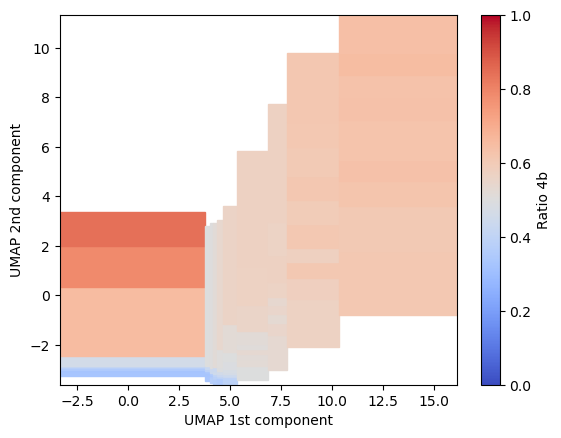

In [ ]:
fig, ax = plt.subplots()


# 10 percentiles of the first component of umap embedding
percentiles = np.percentile(umap_embed_test[:, 0], np.linspace(0, 100, 11))

for i in range(len(percentiles) - 1):
    idx_piece = (umap_embed_test[:, 0] > percentiles[i]) & (umap_embed_test[:, 0] < percentiles[i+1])
    umap_embed_piece = umap_embed_test[idx_piece]
    is_3b_piece = is_3b_test[idx_piece]
    is_bg4b_piece = is_bg4b_test[idx_piece]
    is_hh4b_piece = is_hh4b_test[idx_piece]
    w_piece = w_test[idx_piece]

    # new percentiles
    new_percentiles = np.percentile(umap_embed_piece[:, 1], np.linspace(0, 100, 11))
    hist_piece_3b, _ = np.histogram(umap_embed_piece[is_3b_piece, 1], 
                                       bins=new_percentiles, weights=w_piece[is_3b_piece])
    hist_piece_bg4b, _ = np.histogram(umap_embed_piece[is_bg4b_piece, 1], 
                                         bins=new_percentiles, weights=w_piece[is_bg4b_piece])
    hist_piece_hh4b, _ = np.histogram(umap_embed_piece[is_hh4b_piece, 1], 
                                         bins=new_percentiles, weights=w_piece[is_hh4b_piece])

    ratio_piece_4b = (hist_piece_bg4b + hist_piece_hh4b) / (hist_piece_3b + hist_piece_bg4b + hist_piece_hh4b)
    
    cmap = plt.get_cmap("coolwarm")

    for j in range(len(new_percentiles) - 1):
        # draw a rectangle for each piece
        # fill color based on the ratio 4b
        rect = plt.Rectangle((percentiles[i], new_percentiles[j]), 
                             percentiles[i+1] - percentiles[i], 
                             new_percentiles[j+1] - new_percentiles[j],
                                fill=True, color=cmap(ratio_piece_4b[j]))
        ax.add_patch(rect)

        # ax.text(percentiles[i], new_percentiles[j], f"{ratio_piece_4b[j]:.2f}", fontsize=8)

ax.set_xlabel("UMAP 1st component")
ax.set_ylabel("UMAP 2nd component")
ax.set_xlim(min(umap_embed_test[:, 0]), max(umap_embed_test[:, 0]))
ax.set_ylim(min(umap_embed_test[:, 1]), max(umap_embed_test[:, 1]))

cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap), ax=ax)
cbar.set_label("Ratio 4b")


plt.show()
plt.close()

In [ ]:
train_sb = False

sb_train_dataset = TensorDataset(torch.tensor(X_sb_train, dtype=torch.float32),
                                torch.tensor(y_sb_train, dtype=torch.long),
                                torch.tensor(w_sb_train, dtype=torch.float32))

X_sb_val_torch = torch.tensor(X_sb_val, dtype=torch.float32)
y_sb_val_torch = torch.tensor(y_sb_val, dtype=torch.long)
w_sb_val_torch = torch.tensor(w_sb_val, dtype=torch.float32)

sb_val_dataset = TensorDataset(X_sb_val_torch, y_sb_val_torch, w_sb_val_torch)

# Train SB FvT 

num_classes = 2
dim_input_jet_features = 4
dim_dijet_features = 6
dim_quadjet_features = 6
max_epochs = 30
lr = 1e-3

if train_sb:
    pl.seed_everything(42)

    sb_model = FvTClassifier(num_classes, 
                        dim_input_jet_features, 
                        dim_dijet_features, 
                        dim_quadjet_features, 
                        run_name=sb_run_name,
                        device=torch.device("cuda:0"),
                        lr=lr)

    sb_model.fit(sb_train_dataset, sb_val_dataset, batch_size=1024, max_epochs=max_epochs)

sb_model = FvTClassifier.load_from_checkpoint(f"./checkpoints/{sb_run_name}_best.ckpt")
q_repr_sb_val = get_fvt_reprs(X_sb_val_torch, sb_model)[0]
q_repr_sb_val = np.concatenate(q_repr_sb_val, axis=0)
labels_4b_sb_val = y_sb_val
probs_4b_sb_val = sb_model.predict(X_sb_val_torch)[:, 1].cpu().numpy()
weights_sb_val = w_sb_val

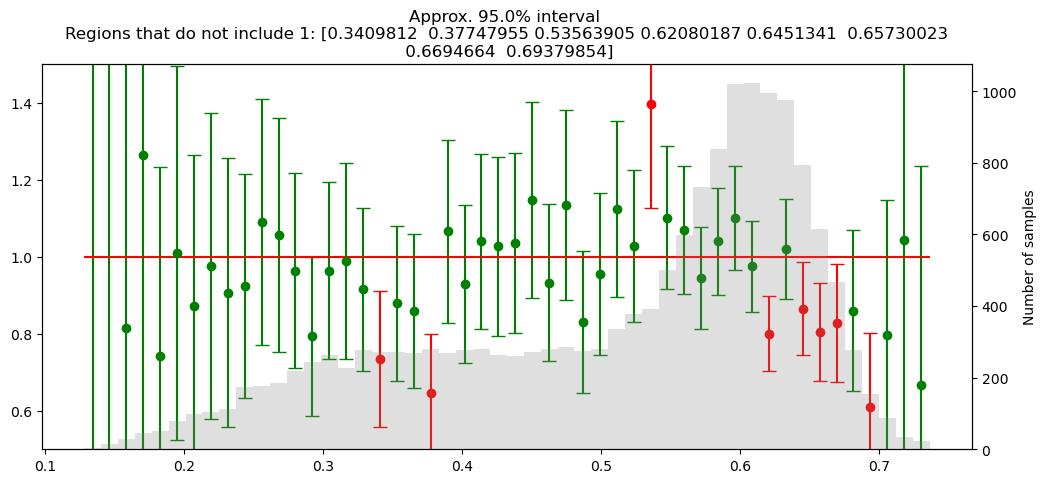

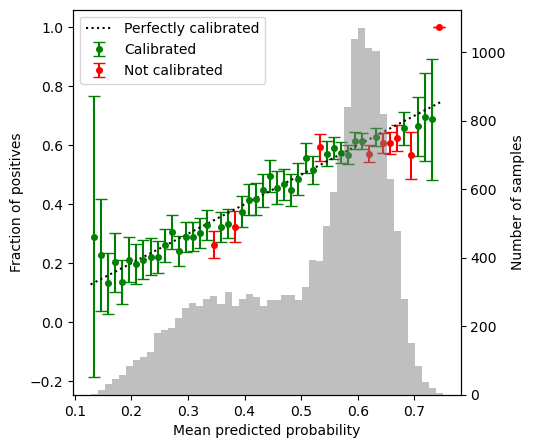

In [ ]:
from plots import plot_prob_weighted_histogram1d, calibration_plot

plot_prob_weighted_histogram1d(probs_4b_sb_val, 
                               probs_4b_sb_val, 
                               labels_4b_sb_val,
                               n_bins=50, 
                               sample_weights=weights_sb_val,
                               ylim=(0.5, 1.5))
calibration_plot(probs_4b_sb_val, labels_4b_sb_val,
                 bins=50,
                 sample_weights=weights_sb_val)

/tmp/ipykernel_1674674/2261626233.py:26: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1674674/2261626233.py:27: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1674674/2261626233.py:28: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1674674/2261626233.py:39: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1674674/2261626233.py:41: RuntimeWarning:

divide by zero encountered in divide

/tmp/ipykernel_1674674/2261626233.py:43: RuntimeWarning:

divide by zero encountered in divide



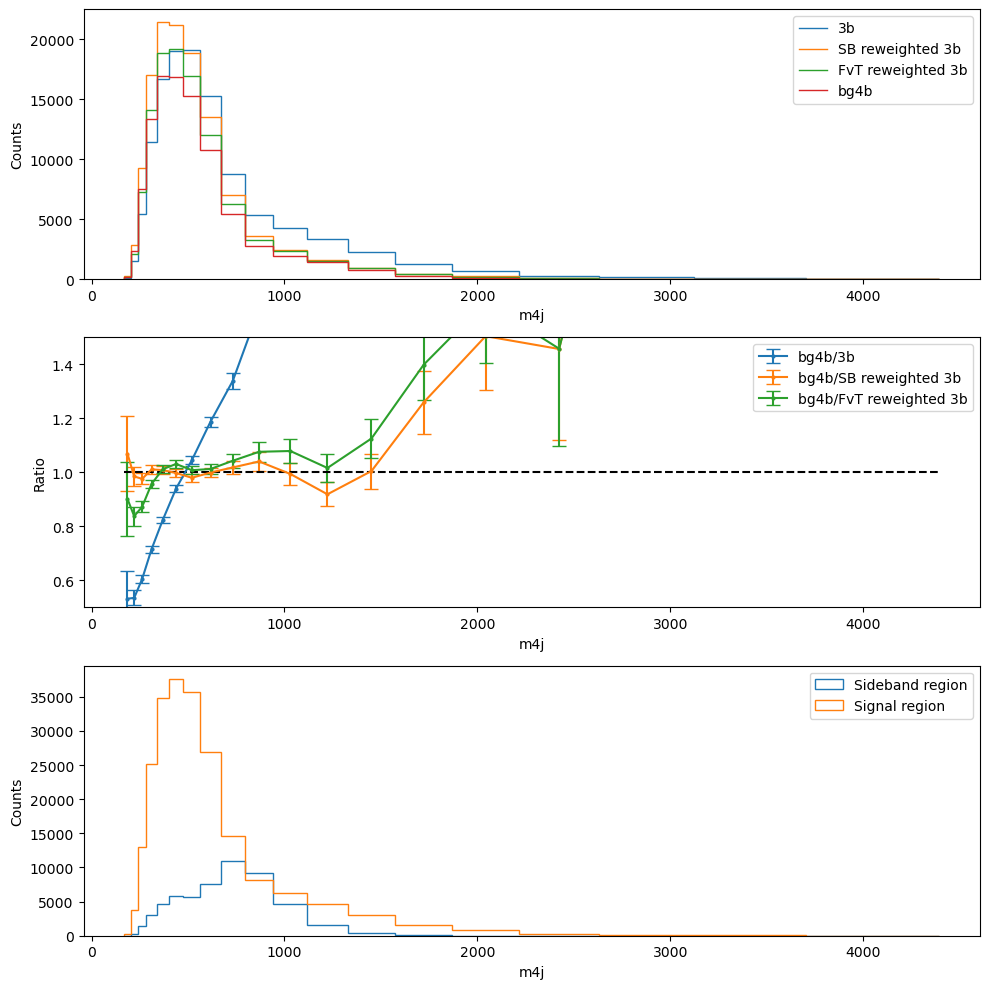

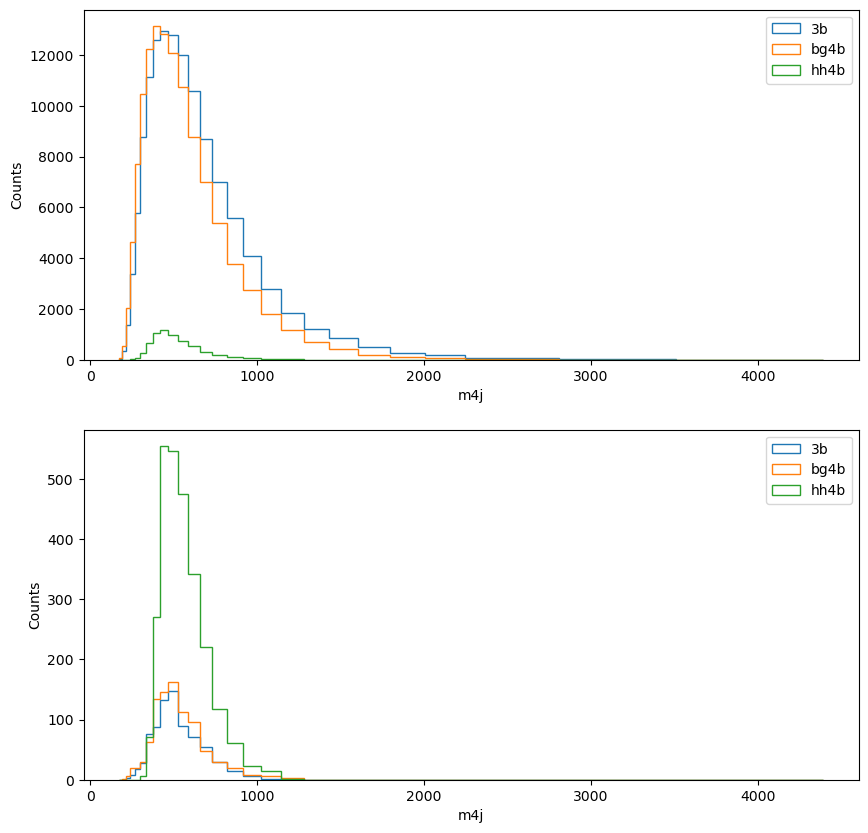

In [ ]:
X_sr_torch = torch.tensor(X_sr, dtype=torch.float32)
probs_4b_sb_sr = sb_model.predict(X_sr_torch)[:, 1].cpu().numpy()
probs_4b_fvt_sr = fvt_model.predict(X_sr_torch)[:, 1].cpu().numpy()

# reweight 3b samples by probs_4b_sb_sr / (1 - probs_4b_sb_sr)

reweights_sb_sr = np.where(is_3b_sr, weights_sr * (probs_4b_sb_sr / (1 - probs_4b_sb_sr)), weights_sr)
reweights_fvt_sr = np.where(is_3b_sr, weights_sr * (probs_4b_fvt_sr / (1 - probs_4b_fvt_sr)), weights_sr)

# histogram of m4j

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
# bins to be a geometric sequence

bins_range = np.geomspace(m4j_sr.min(), m4j_sr.max(), 20)
hist_3b, _ = np.histogram(m4j_sr[is_3b_sr], bins=bins_range, weights=weights_sr[is_3b_sr])
hist_rwsb3b, _ = np.histogram(m4j_sr[is_3b_sr], bins=bins_range, weights=reweights_sb_sr[is_3b_sr])
hist_rwfvt3b, _ = np.histogram(m4j_sr[is_3b_sr], bins=bins_range, weights=reweights_fvt_sr[is_3b_sr])
hist_bg4b, _ = np.histogram(m4j_sr[is_bg4b_sr], bins=bins_range, weights=weights_sr[is_bg4b_sr])

# normalize the histograms
scale_3b = np.sum(hist_bg4b) / np.sum(hist_3b)
scale_rwsb3b = np.sum(hist_bg4b) / np.sum(hist_rwsb3b)
scale_rwfvt3b = np.sum(hist_bg4b) / np.sum(hist_rwfvt3b)

err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b

ax[0].stairs(hist_3b, bins_range, label="3b")
ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
ax[0].set_xlabel("m4j")
ax[0].set_ylabel("Counts")
ax[0].legend()

z = 1.96
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_3b * hist_3b / hist_bg4b, yerr=z * err_3b, 
               fmt="o-", label="bg4b/3b", capsize=5, markersize=2)
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_rwsb3b * hist_rwsb3b / hist_bg4b, yerr=z * err_rw3b, 
               fmt="o-", label="bg4b/SB reweighted 3b", capsize=5, markersize=2)
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_rwfvt3b * hist_rwfvt3b / hist_bg4b, yerr=z * err_rwfvt3b, 
                fmt="o-", label="bg4b/FvT reweighted 3b", capsize=5, markersize=2)
ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
ax[1].set_ylim(0.5, 1.5)
ax[1].set_xlabel("m4j")
ax[1].set_ylabel("Ratio")
ax[1].legend()

ax[2].hist(m4j_sb, bins=bins_range, weights=weights_sb, histtype="step", label="Sideband region")
ax[2].hist(m4j_sr, bins=bins_range, weights=weights_sr, histtype="step", label="Signal region")
ax[2].set_xlabel("m4j")
ax[2].set_ylabel("Counts")
ax[2].legend()

plt.tight_layout()
plt.show()

m4j_test = get_m4j(X_test_torch)


fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 10))
bins_range = np.geomspace(m4j_test.min(), m4j_test.max(), 30)

ax[0].hist(m4j_test[is_3b_test], bins=bins_range, histtype="step", label="3b")
ax[0].hist(m4j_test[is_bg4b_test], bins=bins_range, histtype="step", label="bg4b")
ax[0].hist(m4j_test[is_hh4b_test], bins=bins_range, histtype="step", label="hh4b")
ax[0].set_xlabel("m4j")
ax[0].set_ylabel("Counts")
ax[0].legend()

ax[1].hist(m4j_test[is_3b_test & probs_4b_exceeded], bins=bins_range, histtype="step", label="3b")
ax[1].hist(m4j_test[is_bg4b_test & probs_4b_exceeded], bins=bins_range, histtype="step", label="bg4b")
ax[1].hist(m4j_test[is_hh4b_test & probs_4b_exceeded], bins=bins_range, histtype="step", label="hh4b")
ax[1].set_xlabel("m4j")
ax[1].set_ylabel("Counts")
ax[1].legend()



plt.show()
plt.close()

/tmp/ipykernel_1674674/2277063401.py:28: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/2277063401.py:29: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/2277063401.py:30: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/2277063401.py:41: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/2277063401.py:43: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/2277063401.py:45: RuntimeWarning:

invalid value encountered in divide



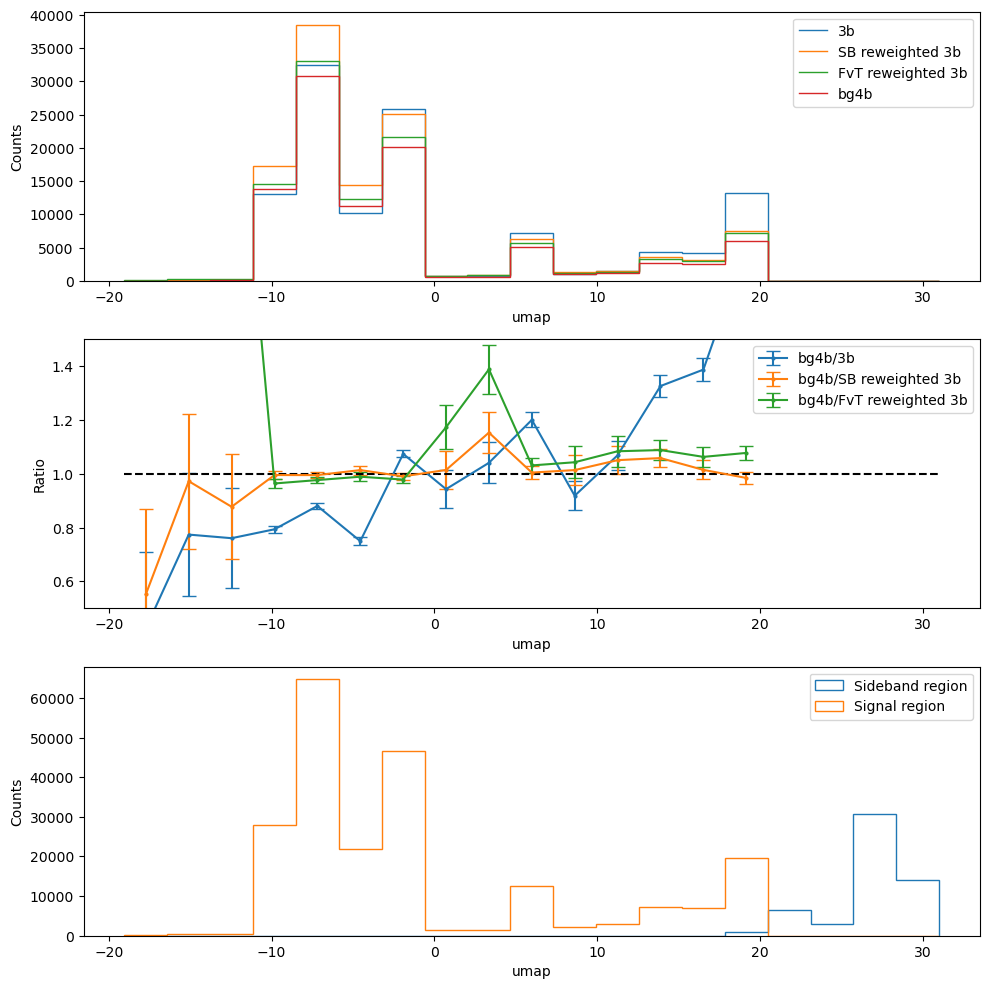

In [ ]:
X_sr_torch = torch.tensor(X_sr, dtype=torch.float32)
probs_4b_sb_sr = sb_model.predict(X_sr_torch)[:, 1].cpu().numpy()
probs_4b_fvt_sr = fvt_model.predict(X_sr_torch)[:, 1].cpu().numpy()

# reweight 3b samples by probs_4b_sb_sr / (1 - probs_4b_sb_sr)

reweights_sb_sr = np.where(is_3b_sr, weights_sr * (probs_4b_sb_sr / (1 - probs_4b_sb_sr)), weights_sr)
reweights_fvt_sr = np.where(is_3b_sr, weights_sr * (probs_4b_fvt_sr / (1 - probs_4b_fvt_sr)), weights_sr)

# histogram of umap

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
umap_embed_sr = umap_embed_test[is_in_sr][:is_3b_sr.shape[0], 0]
umap_embed_sb = umap_embed_test[~is_in_sr][:is_3b_sb.shape[0], 0]

bins_range = np.linspace(min(umap_embed_sr.min(), umap_embed_sb.min()), 
                         max(umap_embed_sr.max(), umap_embed_sb.max()), 20)
hist_3b, _ = np.histogram(umap_embed_sr[is_3b_sr], bins=bins_range, weights=weights_sr[is_3b_sr])
hist_rwsb3b, _ = np.histogram(umap_embed_sr[is_3b_sr], bins=bins_range, weights=reweights_sb_sr[is_3b_sr])
hist_rwfvt3b, _ = np.histogram(umap_embed_sr[is_3b_sr], bins=bins_range, weights=reweights_fvt_sr[is_3b_sr])
hist_bg4b, _ = np.histogram(umap_embed_sr[is_bg4b_sr], bins=bins_range, weights=weights_sr[is_bg4b_sr])

# normalize the histograms
scale_3b = np.sum(hist_bg4b) / np.sum(hist_3b)
scale_rwsb3b = np.sum(hist_bg4b) / np.sum(hist_rwsb3b)
scale_rwfvt3b = np.sum(hist_bg4b) / np.sum(hist_rwfvt3b)

err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b

ax[0].stairs(hist_3b, bins_range, label="3b")
ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
ax[0].set_xlabel("umap")
ax[0].set_ylabel("Counts")
ax[0].legend()

z = 1.96
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_3b * hist_3b / hist_bg4b, yerr=z * err_3b, 
               fmt="o-", label="bg4b/3b", capsize=5, markersize=2)
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_rwsb3b * hist_rwsb3b / hist_bg4b, yerr=z * err_rw3b, 
               fmt="o-", label="bg4b/SB reweighted 3b", capsize=5, markersize=2)
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_rwfvt3b * hist_rwfvt3b / hist_bg4b, yerr=z * err_rwfvt3b, 
                fmt="o-", label="bg4b/FvT reweighted 3b", capsize=5, markersize=2)
ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
ax[1].set_ylim(0.5, 1.5)
ax[1].set_xlabel("umap")
ax[1].set_ylabel("Ratio")
ax[1].legend()

ax[2].hist(umap_embed_sb, bins=bins_range, weights=weights_sb, histtype="step", label="Sideband region")
ax[2].hist(umap_embed_sr, bins=bins_range, weights=weights_sr, histtype="step", label="Signal region")
ax[2].set_xlabel("umap")
ax[2].set_ylabel("Counts")
ax[2].legend()

plt.tight_layout()
plt.show()

/tmp/ipykernel_1674674/514070622.py:23: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/514070622.py:24: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/514070622.py:25: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/514070622.py:36: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/514070622.py:38: RuntimeWarning:

invalid value encountered in divide

/tmp/ipykernel_1674674/514070622.py:40: RuntimeWarning:

invalid value encountered in divide



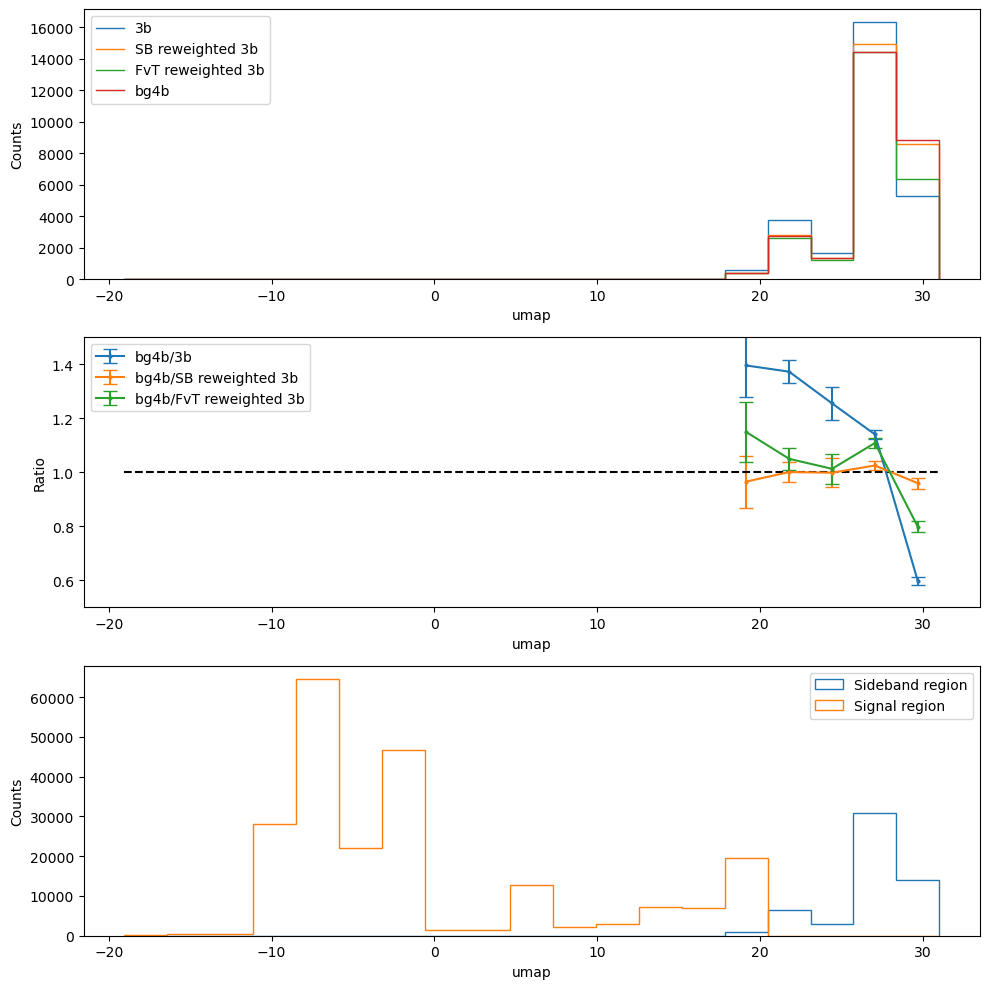

In [ ]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10, 10))
umap_embed_sr = umap_embed_test[is_in_sr][:is_3b_sr.shape[0], 0]
umap_embed_sb = umap_embed_test[~is_in_sr][:is_3b_sb.shape[0], 0]

bins_range = np.linspace(min(umap_embed_sr.min(), umap_embed_sb.min()), 
                         max(umap_embed_sr.max(), umap_embed_sb.max()), 20)
X_sb_torch = torch.tensor(X_sb, dtype=torch.float32)
probs_4b_sb_sb = sb_model.predict(X_sb_torch)[:, 1].cpu().numpy()
probs_4b_fvt_sb = fvt_model.predict(X_sb_torch)[:, 1].cpu().numpy()
reweights_sb_sb = np.where(is_3b_sb, weights_sb * (probs_4b_sb_sb / (1 - probs_4b_sb_sb)), weights_sb)
reweights_fvt_sb = np.where(is_3b_sb, weights_sb * (probs_4b_fvt_sb / (1 - probs_4b_fvt_sb)), weights_sb)

hist_3b, _ = np.histogram(umap_embed_sb[is_3b_sb], bins=bins_range, weights=weights_sb[is_3b_sb])
hist_rwsb3b, _ = np.histogram(umap_embed_sb[is_3b_sb], bins=bins_range, weights=reweights_sb_sb[is_3b_sb])
hist_rwfvt3b, _ = np.histogram(umap_embed_sb[is_3b_sb], bins=bins_range, weights=reweights_fvt_sb[is_3b_sb])
hist_bg4b, _ = np.histogram(umap_embed_sb[is_bg4b_sb], bins=bins_range, weights=weights_sb[is_bg4b_sb])

# normalize the histograms
scale_3b = np.sum(hist_bg4b) / np.sum(hist_3b)
scale_rwsb3b = np.sum(hist_bg4b) / np.sum(hist_rwsb3b)
scale_rwfvt3b = np.sum(hist_bg4b) / np.sum(hist_rwfvt3b)

err_3b = np.sqrt(hist_3b) * scale_3b / hist_bg4b
err_rw3b = np.sqrt(hist_rwsb3b) * scale_rwsb3b / hist_bg4b
err_rwfvt3b = np.sqrt(hist_rwfvt3b) * scale_rwfvt3b / hist_bg4b

ax[0].stairs(hist_3b, bins_range, label="3b")
ax[0].stairs(hist_rwsb3b, bins_range, label="SB reweighted 3b")
ax[0].stairs(hist_rwfvt3b, bins_range, label="FvT reweighted 3b")
ax[0].stairs(hist_bg4b, bins_range, label="bg4b")
ax[0].set_xlabel("umap")
ax[0].set_ylabel("Counts")
ax[0].legend()

z = 1.96
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_3b * hist_3b / hist_bg4b, yerr=z * err_3b, 
               fmt="o-", label="bg4b/3b", capsize=5, markersize=2)
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_rwsb3b * hist_rwsb3b / hist_bg4b, yerr=z * err_rw3b, 
               fmt="o-", label="bg4b/SB reweighted 3b", capsize=5, markersize=2)
ax[1].errorbar((bins_range[1:] + bins_range[:-1]) / 2, scale_rwfvt3b * hist_rwfvt3b / hist_bg4b, yerr=z * err_rwfvt3b, 
                fmt="o-", label="bg4b/FvT reweighted 3b", capsize=5, markersize=2)
ax[1].hlines(1, bins_range[0], bins_range[-1], color="black", linestyle="--")
ax[1].set_ylim(0.5, 1.5)
ax[1].set_xlabel("umap")
ax[1].set_ylabel("Ratio")
ax[1].legend()

ax[2].hist(umap_embed_sb, bins=bins_range, weights=weights_sb, histtype="step", label="Sideband region")
ax[2].hist(umap_embed_sr, bins=bins_range, weights=weights_sr, histtype="step", label="Signal region")
ax[2].set_xlabel("umap")
ax[2].set_ylabel("Counts")
ax[2].legend()

plt.tight_layout()
plt.show()